In [2]:
!pip install yfinance
import yfinance as yf
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import torch 
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

from torch.utils.data import DataLoader

import torch 
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets 
from torchvision.transforms import ToTensor 
import os
from torch import optim
from torch.optim import lr_scheduler
from torch.utils.data.sampler import SubsetRandomSampler
import time

import random

if torch.cuda.is_available():
  device = "cuda"
else:
  device = "cpu"
print(f"available {device} device ")

device = torch.device(device)

     |████████████████████████████████| 6.3 MB 7.4 MB/s 
  Attempting uninstall: lxml
    Found existing installation: lxml 4.2.6
    Uninstalling lxml-4.2.6:
      Successfully uninstalled lxml-4.2.6
available cpu device 


In [ ]:
path = "/content/drive/MyDrive/Models/Pytorch/model.pth"

In [3]:
plt.rcParams["figure.figsize"] = (20,8)


In [4]:
from torch.utils.data import Dataset

def load_latest_model(model, name="model.pt", path='/content'):
    """
    Helper function for Load model
    :param model: current model
    :param name: model name
    :return: loaded model default model.pt
    """
    model.load_state_dict(torch.load(name))
    return model

def train(model, train_loader, test_loader,
          epochs, optimizer, criterion, scheduler=None,
          name="model.pth", path=None):
    """
    Helper function for train model
    :param model: current model
    :param train_loader: train data loader
    :param test_loader: test data loader
    :param epochs: number of epoch
    :param optimizer: optimizer
    :param criterion: loss function
    :param scheduler: scheduler, default None
    :param name: model name, default model.pt
    :param path: model saved location, default None
    :return: model, list of train loss and test loss
    """

    # compare overfitted
    train_loss_data, valid_loss_data = [], []
    # check for validation loss
    valid_loss_min = np.Inf
    # calculate time
    since = time.time()

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    for epoch in range(epochs):
        print("Epoch: {}/{}".format(epoch + 1, epochs))
        # monitor training loss
        train_loss = 0.0
        valid_loss = 0.0
        total = 0
        
        e_since = time.time()

        ###################
        # train the model #
        ###################
        model.train()  # prep model for training

        for targets, labels in train_loader:
            # Move input and label tensors to the default device
            targets ,labels = targets.float(), labels.float()
            targets, labels = targets.to(device), labels.to(device)
            
            # clear the gradients of all optimized variables
            optimizer.zero_grad()
            # forward pass: compute predicted outputs by passing inputs to the model
            ps = model(targets)
            # calculate the loss
            
            loss = criterion(ps, labels)
            # backward pass: compute gradient of the loss with respect to model parameters
            loss.backward()
            # perform a single optimization step (parameter update)
            optimizer.step()
            # update running training loss
            train_loss += loss.item() * targets.size(0)

        ######################
        # validate the model #
        ######################
        print("\t\tGoing for validation")
        model.eval()  # prep model for evaluation
        for data, target in test_loader:
            # Move input and label tensors to the default device
            data, target = data.float(), target.float()
            data, target = data.to(device), target.to(device)
            #target=target.view(-1,1)
            # forward pass: compute predicted outputs by passing inputs to the model
            output = model(data)
            # calculate the loss
            loss_p = criterion(output, target)
            # update running validation loss
            valid_loss += loss_p.item() * data.size(0)
            # calculate accuracy
            

        # print training/validation statistics
        # calculate average loss over an epoch
        train_loss = train_loss / len(train_loader.dataset)
        valid_loss = valid_loss / len(test_loader.dataset)

        # calculate train loss and running loss
        train_loss_data.append(train_loss * 100)
        valid_loss_data.append(valid_loss * 100)

        print("\tTrain loss:{:.6f}..".format(train_loss),
              "\tValid Loss:{:.6f}..".format(valid_loss))
            #  "\tAccuracy: {:.4f}".format(1/train_loss)

        if scheduler is not None:
            scheduler.step()  # step up scheduler

        # save model if validation loss has decreased
        if valid_loss <= valid_loss_min:
            print('\tValidation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
                valid_loss_min,
                valid_loss))
            torch.save(model.state_dict(), name)
            valid_loss_min = valid_loss
            # save to google drive
            if path is not None:
                torch.save(model.state_dict(), path)

        # Time take for one epoch
        time_elapsed = time.time() - e_since
        print('\tEpoch:{} completed in {:.0f}m {:.0f}s'.format(
            epoch + 1, time_elapsed // 60, time_elapsed % 60))

    # compare total time
    time_elapsed = time.time() - since
    print('Training completed in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))

    # load best model
  
    model = load_latest_model(model, name, path)

    
    # return the model
    return [model, train_loss_data, valid_loss_data]


class CustomTimeSeries(Dataset):
    def __init__(self, x,y):
        x = np.reshape(x, (x.shape[0],x.shape[1],x.shape[2]))
        self.features = x.astype(np.float32)
        self.labels = y.astype(np.float32)
  

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        x = self.features[idx,:,:]
        y = self.labels[idx]
        return x, y







In [ ]:
import torch.nn.functional as F
from torch.autograd import Variable
class tradeloss(nn.Module):
  def __init__(self):
    super().__init__()
    self.device = "cuda:0" if torch.cuda.is_available() else 'cpu'
  def forward(self,pred,target):
    pred,target = pred.squeeze(),target.squeeze()
    y_true_next = target[:,1:]
    y_pred_next = pred[:,1:]
    y_true_tdy = target[:,:-1]
    y_pred_tdy = pred[:,:-1]


    y_true_diff = y_true_next - y_true_tdy
    y_pred_diff = y_pred_next - y_pred_tdy

    standard = torch.zeros_like(y_pred_diff)
    y_true_move = torch.gt(y_true_diff,standard)
    y_pred_move = torch.gt(y_pred_diff,standard)

    condition = torch.ne(y_true_move,y_pred_move)

    alpha =1000*torch.ones_like(y_pred_tdy,dtype=torch.float32,device=self.device)
    ones = torch.ones_like(y_pred_tdy,dtype=torch.float32,device=self.device)
    indexes = torch.where(y_true_move != y_pred_move,alpha,ones)
    ones = torch.ones((pred.shape[0],1),dtype=torch.float32, device=self.device)
    indexes = torch.cat([indexes,ones],dim=1)
    indexes = indexes.to(self.device)
    diff = torch.absolute(pred - target) * indexes
    y = torch.tensor([[i+1 for i in range(diff.shape[1])]], dtype = torch.float32, device=self.device, requires_grad=True) # peanlize more on earlier time predictions
    y = y.broadcast_to((diff.shape[0],diff.shape[1]))     #broadcast
    
    diff = diff*y                   #multiply with diff
    
    loss = torch.mean(diff, 1)
    
    loss_overall = torch.mean(loss)
    
    return loss_overall


In [ ]:
import torch.nn.functional as F
from torch.autograd import Variable
class tradeloss_2(nn.Module):
  def __init__(self):
    super().__init__()
    self.device = "cuda:0" if torch.cuda.is_available() else 'cpu'
  def forward(self,pred,target):
    pred,target = pred.squeeze(),target.squeeze()
    y_true_next = target[:,1:]
    y_pred_next = pred[:,1:]
    y_true_tdy = target[:,:-1]
    y_pred_tdy = pred[:,:-1]


    y_true_diff = y_true_next - y_true_tdy
    y_pred_diff = y_pred_next - y_pred_tdy

    standard = torch.zeros_like(y_pred_diff)
    y_true_move = torch.gt(y_true_diff,standard)
    y_pred_move = torch.gt(y_pred_diff,standard)

    condition = torch.ne(y_true_move,y_pred_move)

    alpha =1000*torch.ones_like(y_pred_tdy,dtype=torch.float32,device=self.device)
    ones = torch.ones_like(y_pred_tdy,dtype=torch.float32,device=self.device)
    indexes = torch.where(y_true_move != y_pred_move,alpha,ones)
    ones = torch.ones((pred.shape[0],1),dtype=torch.float32, device=self.device)
    indexes = torch.cat([indexes,ones],dim=1)
    indexes = indexes.to(self.device)
    diff = torch.absolute(pred - target) * indexes
    y = torch.tensor([[i+10 for i in range(diff.shape[1],0,-1)]], dtype = torch.float32, device=self.device) # peanlize more on earlier time predictions
    y = y.broadcast_to((diff.shape[0],diff.shape[1]))     #broadcast
    
    diff = diff*y                   #multiply with diff
    
    loss = torch.mean(diff, 1)
    
    loss_overall = torch.mean(loss)
    
    return loss_overall


In [ ]:
 plot_data(mod2,test_dataloader,random_range=322,row=10,col=5,days=8,randomized=True)


In [5]:
def plot_data(model,data,random_range,row=10,col=8,days=7,randomized=False):
  preds = np.empty([0,10])
  targets = np.empty([0,10])
  figure, axis = plt.subplots(row ,col)
  model.eval()
  
  for input , target in data:
    input = input.float()
    if torch.cuda.is_available():
      input= input.cuda()
    pred = model(input)
    
    pred = pred.cpu().detach().numpy().squeeze()
    target = target.cpu().detach().numpy().squeeze()
    preds = np.concatenate([pred,preds],axis=0)
    targets = np.concatenate([target,targets],axis=0)
  print(preds.shape)

  if randomized:
    random = np.random.randint(0,random_range,row*col)
    
  else:  
    random = [i for i in range(random_range,random_range+row*col)]
 
  #pred = pred[random:random+4]
  #target = target[random:random+4]
  k=0
  for i in range(row):
    for j in range(col):
       
       axis[i,j].plot(preds[random[k],:days])
       axis[i,j].plot(targets[random[k],:days])
       plt.title(f'{k}')
       k=k+1
       


  return preds,targets


def plot_models(model,data):
  for i in model:
    plot_data(i,data)

In [5]:
class StockData():
  def __init__(self,ticker,min_max=False):
    
    self.data = None
    self.min_max_y =None
    self.min_max_data = None
    self.ticker = ticker
    self.download(ticker)
    self.features()
    self.signals()
    self.data.dropna(inplace=True)
    self.dataframe_out()
    print(self.data.columns)
    self.new_dataset()
    self._pre_minmax()
    return 
  
  def dataframe_out(self, columns = ['Adj Close','Adj Close MA 20','Adj Close MA 10','Adj Close MA 3','Volume','signals']):
    self.data = self.data[columns]
    return 

  def features(self,roll_ma=[3,10,20],roll_dma=10,shift_dma=3,scle=10):
    self.data['Adj Close MA 3'] = self.data['Adj Close'].rolling(roll_ma[0]).mean()
    self.data['Adj Close MA 20'] = self.data['Adj Close MA 3'].rolling(roll_ma[2]).mean()
    self.data['Adj Close MA 10'] = self.data['Adj Close MA 3'].rolling(roll_ma[1]).mean()
    
    #self.data['d_close'] = 10*(self.data['Adj Close MA']- self.data['Adj Close MA'].shift(shift_dma)).rolling(roll_dma).mean()
    
    #self.data['d_cma'] = self.data['Adj Close MA'] + self.data['d_close']
    
    #self.data['dd_cma'] = self.data['d_cma']- self.data['d_cma'].shift(shift_dma)
    
    return
  def signals(self,column='Adj Close MA 20'):
    
    res,_ = find_peaks(self.data[column])
    res2,_ = find_peaks(-self.data[column])
    res = np.sort(np.concatenate((res,res2),axis=-1))
    peaks = df.iloc[indexes]['Adj Close']
    dates = df.iloc[indexes].index
    self.data['signals']=0
 
    
    for i in range(len(peaks)-3):
      a,b,c,d = peaks[i],peaks[i+1],peaks[i+2],peaks[i+3]
      if (b - a > 0)|(c-a >0):
        if (c-a > 0 )|(d -a > 0 ):
          if (d-a > 0 ):
            self.data.loc[dates[i],['signals']]=3
          
            continue
        
          self.data.loc[dates[i],['signals']]=2
          continue
      
        self.data.loc[dates[i],['signals']]=1
      else:
        
        
        self.data.loc[dates[i],['signals']]=-1
    return 

  @staticmethod
  def train_test_val_split(X,Y,split = 0.1, val = True,shuffle=True):
    x1,x2,y1,y2 = train_test_split(X, Y, test_size=0.1, shuffle=False)
    if val:
      x1,x3,y1,y3 = train_test_split(x1, y1, test_size=0.1, shuffle=shuffle)
      return x1,x3,x2,y1,y3,y2
    else:
      return x1,x2,y1,y2

  def download(self,ticker,Id=".NS"):
    if self.data == None:
      if type(ticker) == str:
        ticker = ticker + Id
        self.data = yf.download(ticker)
 

  def new_dataset(self, step_size=100, pred_period=10):
    dataset = self.data.to_numpy()
    data_X, data_Y = [], []
    for i in range(dataset.shape[0]-step_size-pred_period-1):
# here is the inclusion of features for the model
        a = dataset[i:(i+step_size)]
        data_X.append(a)
        data_Y.append(dataset[i+step_size :(i+step_size + pred_period), -1])
    self.X,self.Y=  np.array(data_X), np.array(data_Y)
    return
  
  def _pre_minmax(self):
    self.min_max_data = MinMaxScaler()
    self.min_max_y = MinMaxScaler()
    self.min_max_data.fit(self.data.to_numpy()[:])
    self.min_max_y.fit(self.data.to_numpy()[:,-1].reshape(-1,1))
    return 

  def min_max(self):
    scaled_X = []
    scaled_Y = []
    for i in range(len(self.X)):
      x = self.min_max_data.transform(self.X[i])
      
      y = self.min_max_y.transform(self.Y[i].reshape(-1,1))
      
      scaled_X.append(x)
      scaled_Y.append(y)
      
    
    self.X_scaled, self.Y_scaled = np.array(scaled_X), np.array(scaled_Y)
    #print(self.Y_scaled.shape)
    return self.X_scaled, self.Y_scaled




#prepare everything

def prepare(tickers,min_max=False,batch=32,shuffle=False,id=".NS"):
  X ,Y = [],[]
  k=1
  for ticker in tickers:
    data = StockData(ticker=ticker,min_max=min_max)
    x,y = data.min_max()
    if k==1:
      X = x
      Y = y
    else:
      X = np.concatenate([X,x],0)
      Y = np.concatenate([Y,y], 0)
    k=k+1
  print(X.shape)
  x_train,x_val,x_test,y_train,y_val, y_test = data.train_test_val_split(X,Y,shuffle=shuffle)
  x_train= x_train[len(x_train)%batch:]
  y_train = y_train[len(y_train)%batch:] 
  x_val = x_val[len(x_val)%batch:]
  y_val = y_val[len(y_val)%batch:]
  x_test = x_test[len(x_test)%batch:]
  y_test = y_test[len(y_test)%batch:]
  print(f"len x_train {x_train.shape}, y_train {len(y_train)}; x_val{x_val.shape}; y val {len(y_val)} ; x test {x_test.shape} y test {len(y_test)}")
  traindata = CustomTimeSeries(x_train,y_train)
  train_dataloader = DataLoader(traindata, batch_size=batch, shuffle=False)
  valdata = CustomTimeSeries(x_val,y_val)
  val_dataloader = DataLoader(valdata, batch_size=batch, shuffle=False)
  testdata = CustomTimeSeries(x_test,y_test)

  test_dataloader = DataLoader(testdata, batch_size=batch, shuffle=False)
  return train_dataloader, val_dataloader, test_dataloader

In [6]:
data = StockData('TATAMOTORS')

[*********************100%***********************]  1 of 1 completed
Index(['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume', 'Adj Close MA 3',
       'Adj Close MA', 'Adj Close MA 10', 'd_close', 'd_cma', 'dd_cma'],
      dtype='object')


In [7]:
data.data

,Open,High,Low,Close,Adj Close,Volume,Adj Close MA 3,Adj Close MA,Adj Close MA 10,d_close,d_cma,dd_cma
Date,,,,,,,,,,,,
1996-02-13,82.247856,84.116249,80.676483,81.902916,60.142799,150810,60.912062,54.020402,56.029385,3.452274,57.472676,4.966287
1996-02-14,81.902916,84.700722,82.401154,82.420319,60.522724,162552,60.353878,54.388614,56.948741,4.957604,59.346218,5.472403
1996-02-15,82.420319,82.784416,80.494431,82.247856,60.396111,51400,60.353878,54.760578,57.791641,6.362556,61.123133,5.532091
1996-02-16,82.247856,81.433426,79.526695,80.053680,58.784874,50879,59.901236,55.110144,58.428155,7.560065,62.670210,5.197534
1996-02-19,80.053680,81.423843,77.610390,78.606873,57.722462,54010,58.967815,55.401548,58.831781,8.455149,63.856696,4.510479
...,...,...,...,...,...,...,...,...,...,...,...,...
2021-11-24,499.000000,501.799988,485.299988,488.649994,488.649994,20915837,490.083333,499.110834,507.181670,98.018336,597.129170,-60.389162
2021-11-25,490.799988,495.149994,486.500000,492.750000,492.750000,15336539,492.299998,499.079168,505.685004,76.037504,575.116672,-63.486662
2021-11-26,486.000000,486.750000,458.000000,460.200012,460.200012,51787989,480.533335,498.448335,502.943337,54.892505,553.340840,-65.402495


In [10]:
df = data.data[4000:4500]

In [ ]:
def signals(self):
  df = self.data.copy()
  res,_ = find_peaks(df['Adj Close MA 10'])
  res2,_ = find_peaks(-df['Adj Close MA 10'])
  res = np.sort(np.concatenate((res,res2),axis=-1))
  peaks = dataframe.iloc[indexes]['Adj Close']
  dates = dataframe.iloc[indexes].index
  dataframe['signals']=0
 
  print(dates)
  for i in range(len(peaks)-3):
    a,b,c,d = peaks[i],peaks[i+1],peaks[i+2],peaks[i+3]
    if (b - a > 0)|(c-a >0)|(d -a > 0 ):
      if (c-a > 0 ):
        if (d-a > 0 ):
          dataframe.loc[dates[i],['signals']]=3
          
          continue
        
        dataframe.loc[dates[i],['signals']]=2
        continue
      
      dataframe.loc[dates[i],['signals']]=1
    else:
      if(b-a<0)|(c-a<0):
        
        dataframe.loc[dates[i],['signals']]=-1

  
  
  return dataframe

In [11]:
import scipy
from scipy.signal import find_peaks

In [12]:
res,_ = find_peaks(df['Adj Close MA 10'])
res2,_ = find_peaks(-df['Adj Close MA 10'])

In [13]:
res = np.sort(np.concatenate((res,res2),axis=-1))
res 

array([  9,  23,  31,  38,  84,  89, 100, 107, 126, 156, 169, 189, 210,
       216, 235, 236, 240, 251, 253, 254, 261, 268, 305, 321, 329, 335,
       343, 359, 384, 390, 399, 416, 426, 427, 437, 443, 454, 457, 493,
       496])

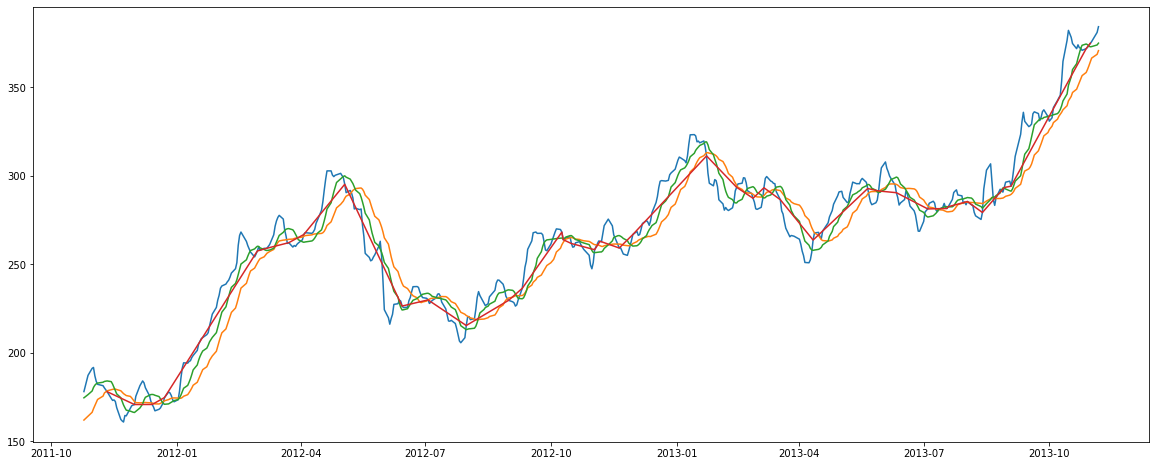

In [14]:
def plot_multiple(*datas):
  for dat in datas:
    plt.plot(dat)
  return
plot_multiple(df['Adj Close MA 3'],df['Adj Close MA'], df['Adj Close MA 10'],df.iloc[res]['Adj Close MA 3'])

In [ ]:
plt.plot(sig['signals'])

In [15]:
len(res)

40

In [44]:
def signals(dataframe,indexes):
  peaks = dataframe.iloc[indexes]['Adj Close']
  dates = dataframe.iloc[indexes].index
  dataframe['signals']=0
 
  print(dates)
  for i in range(len(peaks)-3):
    a,b,c,d = peaks[i],peaks[i+1],peaks[i+2],peaks[i+3]
    if (b - a > 0)|(c-a >0)|(d -a > 0 ):
      if (c-a > 0 ):
        if (d-a > 0 ):
          dataframe.loc[dates[i],['signals']]=3
          
          continue
        
        dataframe.loc[dates[i],['signals']]=2
        continue
      
      dataframe.loc[dates[i],['signals']]=1
    else:
      if(b-a<0)|(c-a<0):
        
        dataframe.loc[dates[i],['signals']]=-1

  
  
  return dataframe
sig = signals(df,res)
pd.unique(sig['signals'])

DatetimeIndex(['2011-11-11', '2011-12-01', '2011-12-14', '2011-12-23',
               '2012-02-29', '2012-03-07', '2012-03-23', '2012-04-03',
               '2012-05-03', '2012-06-14', '2012-07-03', '2012-07-31',
               '2012-08-31', '2012-09-10', '2012-10-09', '2012-10-10',
               '2012-10-16', '2012-11-02', '2012-11-06', '2012-11-07',
               '2012-11-20', '2012-11-30', '2013-01-23', '2013-02-14',
               '2013-02-26', '2013-03-06', '2013-03-18', '2013-04-11',
               '2013-05-21', '2013-05-29', '2013-06-11', '2013-07-04',
               '2013-07-18', '2013-07-19', '2013-08-02', '2013-08-13',
               '2013-08-29', '2013-09-03', '2013-10-28', '2013-10-31'],
              dtype='datetime64[ns]', name='Date', freq=None)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1763: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)


array([ 0,  1,  3,  2, -1])

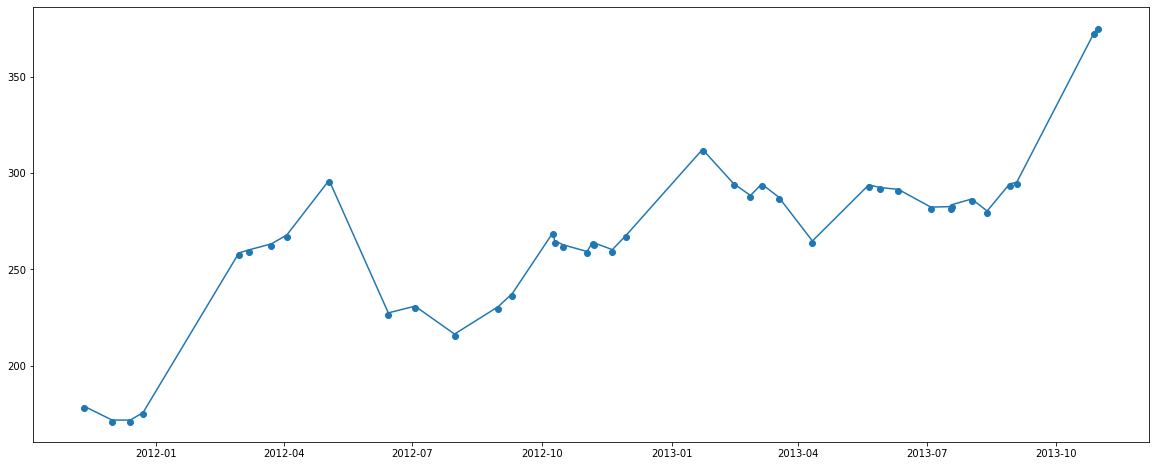

In [96]:
plt.scatter(df.iloc[res].index,df.iloc[res]['Adj Close MA 3'])
plt.plot(df.iloc[res]['Adj Close MA 3']+1)

ValueError: ignored

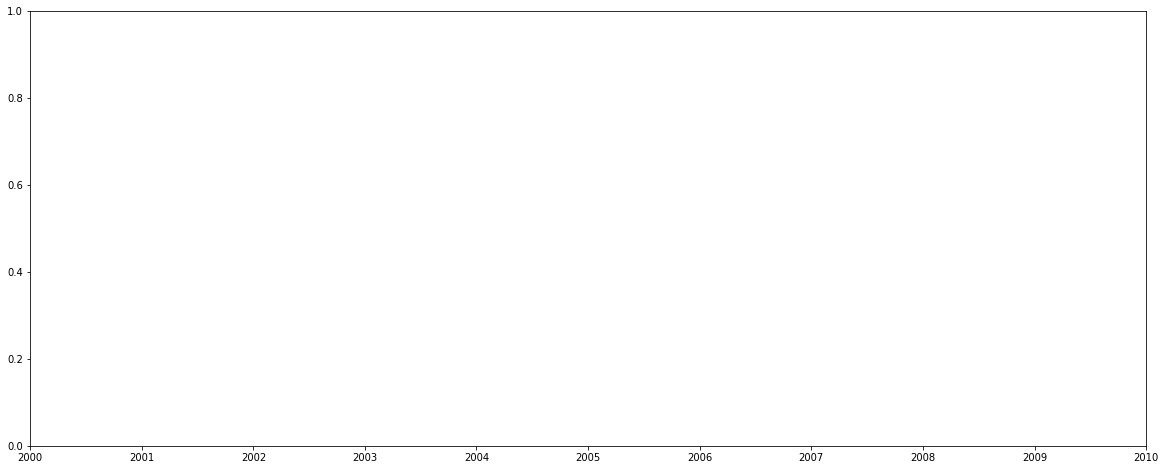

In [97]:
plt.bar(df.iloc[res].index,height=sig)

In [ ]:
import torch


class LSTM(nn.Module):
  def __init__(self,batch,pred_period=10,lookout_days =100, lstm_hid = 1024,dense = 512, input_features=5):
    super().__init__()
    self.batch = batch
    self.period = pred_period 
    self.input_size = input_features
    self.hidden_size = lstm_hid
    self.dense_neurons = dense
    self.enc_seq_len = lookout_days

    self.lstm = nn.LSTM(input_size=self.input_size,hidden_size=self.hidden_size ,num_layers=2,batch_first=True)
    self.lstm_cell = nn.LSTMCell(input_size=self.hidden_size,hidden_size=self.hidden_size)
    self.act1 = nn.Tanh()
    self.attention = AdditiveAttention(hidden_state=self.hidden_size,num_hiddens=dense, period=self.enc_seq_len, dropout=0.5, batch=batch)
    self.dense1 = nn.Linear(in_features=self.hidden_size, out_features=self.dense_neurons)
    #New line
    
    self.dense = nn.Linear(in_features=self.dense_neurons, out_features=1)
    self.dropout = nn.Dropout(0.6)

  def forward(self,x):
    
    out,(hx,cx) = self.lstm(x)
    self.attention.load_hidden(out)
  
    hx = hx[1].squeeze()
    cx = cx[1].squeeze()
    hidden = self.init_hidden()
    (hx1,cx1) =hidden
    
    output = torch.empty((self.period,self.batch,self.hidden_size))
    if torch.cuda.is_available():
        hx1,cx1 = hx1.cuda(),cx1.cuda()
        output = output.cuda()
    hx1 = hx
    for i in range(self.period):
      cnt = self.attention(hx1)
      
      hx1,cx = self.lstm_cell(cnt,(hx1,cx))
      output[i] = hx1
      
    
    output = output.permute(1,0,2)
    output = self.act1(self.dropout(self.dense1(output)))
    #new line
    
    output = self.dense(output)
    return output

  def init_hidden(self):
    return  (torch.zeros(self.batch,self.hidden_size ,dtype=torch.float32,requires_grad=True),
                   torch.zeros(self.batch,self.hidden_size ,dtype=torch.float32,requires_grad=True))
    
class AdditiveAttention(nn.Module):

  def __init__(self, hidden_state, num_hiddens,period, dropout,batch, **kwargs):
    super(AdditiveAttention, self).__init__()
    self.period = period
    self.W_enc = nn.Linear( hidden_state, num_hiddens, bias=False)
    
    self.W_hx = nn.Linear( hidden_state, num_hiddens ,bias=False)
    
    
    self.w_v = nn.Linear(num_hiddens,1,bias=False)
    self.w_u = nn.Linear(period,hidden_state,bias = False)
    self.dropout = nn.Dropout(dropout)
  def forward(self,hx1):
    hx = hx1.unsqueeze(axis=1).broadcast_to((hx1.shape[0],self.period,hx1.shape[1]))
    features = self.W_hx(hx) + self.W_enc(self.out_enc)
    scores= torch.tanh(self.dropout(self.w_v(features)))
    softmax = nn.functional.softmax(scores, dim=1)
    hx =  hx1.unsqueeze(1)
    
    weights = hx*softmax
    weights = torch.sum(weights, dim=1)
    
    
   
    return weights

  def load_hidden(self,out_enc):
    
    self.out_enc =out_enc
    return
model = LSTM((batch if batch else 32))
model.cuda() 
# best overall  

In [ ]:
import torch

#new : LSTM looks into only volume , dma ,ddma closing price , and uses a different lstm cell to look into 100 days of data then predict 10 days worth of next day plus attention total lenth 110
class AdditiveAttention(nn.Module):

  def __init__(self, hidden_state, num_hiddens,period, dropout,batch, **kwargs):
    super(AdditiveAttention, self).__init__()
    self.period = period
    self.W_enc = nn.Linear( hidden_state, num_hiddens, bias=False)
    
    self.W_hx = nn.Linear( hidden_state, num_hiddens ,bias=False)
    
    
    self.w_v = nn.Linear(num_hiddens,1,bias=False)
    self.w_u = nn.Linear(period,hidden_state,bias = False)
    self.dropout = nn.Dropout(dropout)
  def forward(self,hx1):
    hx = hx1.unsqueeze(axis=1).broadcast_to((hx1.shape[0],self.period,hx1.shape[1]))
    features = self.W_hx(hx) + self.W_enc(self.out_enc)
    scores= torch.tanh(self.dropout(self.w_v(features)))
    softmax = nn.functional.softmax(scores, dim=1)
    hx =  hx1.unsqueeze(1)
    
    weights = hx*softmax
    weights = torch.sum(weights, dim=1)
    
    
   
    return weights

  def load_hidden(self,out_enc):
    
    self.out_enc =out_enc
    return
    

class LSTM2(nn.Module):
  def __init__(self,batch,pred_period=10,lookout_days =100, lstm_hid = 64,dense = 256, input_features=4,teacher_enforce=0.5):
    super().__init__()
    self.batch = batch
    self.period = pred_period 
    self.input_size = input_features
    self.hidden_size = lstm_hid
    self.dense_neurons = dense
    self.enc_seq_len = lookout_days
    self.device = ("cuda" if torch.cuda.is_available() else "cpu")
    self.teacher_enforce = teacher_enforce

    self.lstm = nn.LSTM(input_size=self.input_size,hidden_size=self.hidden_size ,num_layers=2,batch_first=True)
    self.lstm_cell = nn.LSTMCell(input_size=1,hidden_size=self.hidden_size)
    self.lstm_cell2 = nn.LSTMCell(input_size=self.hidden_size,hidden_size=self.hidden_size)
    
    self.attention = AdditiveAttention(hidden_state=self.hidden_size,num_hiddens=dense, period=self.enc_seq_len, dropout=0.5, batch=batch)
    self.dense1 = nn.Linear(in_features=self.hidden_size, out_features=self.dense_neurons)
    self.dense = nn.Linear(in_features=self.hidden_size, out_features=1)
    self.dropout = nn.Dropout(0.3)

    #New line
    self.act1 = nn.Sigmoid()
    self.act2 = nn.ReLU()
    #self.dense2 = nn.Linear(in_features=self.hidden_size, out_features=1,bias=False)
    
  def forward(self,x):
    x1 = x[:,:,0:-1]
    x = x[:,:,-1].unsqueeze(-1)
    
    out,(hx,cx) = self.lstm(x1)
    self.attention.load_hidden(out)

    hidden = self.init_hidden()
    (hx1,cx1) =hidden
    
    
    for i in range(self.enc_seq_len):
        hx1,cx1 = self.lstm_cell(x[:,i,:],(hx1,cx1))
        hx2 = self.attention(hx1)
        f = torch.rand([1],dtype=torch.float32,requires_grad = False, device=self.device)
        hx1 = (hx1 if f>self.teacher_enforce else hx2)


    
    
    
    output = torch.empty((self.period,self.batch,self.hidden_size),device=self.device,dtype=torch.float32)
    
    for i in range(self.period):
      
      cnt = self.attention(hx1)
      #cnt = self.act2(self.dropout(self.dense2(cnt)))
      
      hx1,cx = self.lstm_cell2(cnt,(hx1,cx1))
      output[i] = hx1
      
    
    output = output.permute(1,0,2)
    
    #output = self.act1(self.dropout(self.dense1(output)))
    #new line
    
    output = self.dense(output)
    return output

  def init_hidden(self):
    return  (torch.zeros(self.batch,self.hidden_size ,dtype=torch.float32,requires_grad=True,device=self.device),
                   torch.zeros(self.batch,self.hidden_size ,dtype=torch.float32,requires_grad=True,device=self.device))
    
model = LSTM2((batch if batch else 32))
model.cuda()

# best on trade losss
# adagrad opt lr=0.001 
# valid loss = 8.9 
# 15 epcs * 3 

In [ ]:
import torch

#new :CONV1d approach . BEst!! 
class AdditiveAttention(nn.Module):

  def __init__(self, hidden_state, num_hiddens,period, dropout,batch, **kwargs):
    super(AdditiveAttention, self).__init__()
    self.period = period
    self.W_enc = nn.Linear( hidden_state, num_hiddens, bias=False)
    
    self.W_hx = nn.Linear( hidden_state, num_hiddens ,bias=False)
    
    
    self.w_v = nn.Linear(num_hiddens,1,bias=False)
    self.w_u = nn.Linear(period,hidden_state,bias = False)
    self.dropout = nn.Dropout(dropout)
  def forward(self,hx1):
    hx = hx1.unsqueeze(axis=1).broadcast_to((hx1.shape[0],self.period,hx1.shape[1]))
    features = self.W_hx(hx) + self.W_enc(self.out_enc)
    scores= torch.tanh(self.dropout(self.w_v(features)))
    softmax = nn.functional.softmax(scores, dim=1)
    hx =  hx1.unsqueeze(1)
    
    weights = hx*softmax
    weights = torch.sum(weights, dim=1)
    
    
   
    return weights

  def load_hidden(self,out_enc):
    
    self.out_enc =out_enc
    return
    

class LSTM3(nn.Module):
  def __init__(self,batch,pred_period=10,lookout_days =100, lstm_hid = 64,dense = 256, input_features=4,teacher_enforce=0.5):
    super().__init__()
    self.batch = batch
    self.period = pred_period 
    self.input_size = input_features
    self.hidden_size = lstm_hid
    self.dense_neurons = dense
    self.enc_seq_len = lookout_days
    self.device = ("cuda" if torch.cuda.is_available() else "cpu")
    self.teacher_enforce = teacher_enforce

    self.lstm = nn.LSTM(input_size=self.input_size,hidden_size=self.hidden_size ,num_layers=2,batch_first=True)
    self.lstm_cell = nn.LSTMCell(input_size=1,hidden_size=self.hidden_size)
    self.lstm_cell2 = nn.LSTMCell(input_size=self.hidden_size,hidden_size=self.hidden_size)
    
    self.attention = AdditiveAttention(hidden_state=self.hidden_size,num_hiddens=dense, period=self.enc_seq_len, dropout=0.5, batch=batch)
    self.dense1 = nn.Linear(in_features=(self.hidden_size+ self.period), out_features=self.dense_neurons)
    self.dense = nn.Linear(in_features=self.dense_neurons, out_features=1)
    self.dropout = nn.Dropout(0.3)

    #New line
    self.act1 = nn.Sigmoid()
    self.act2 = nn.ReLU()
    #self.dense2 = nn.Linear(in_features=self.hidden_size, out_features=1,bias=False)
    
  def forward(self,x):
    x1 = x[:,:,0:-1]
    x = x[:,:,-1].unsqueeze(-1)
    
    out,(hx,cx) = self.lstm(x1)
    self.attention.load_hidden(out)

    hidden = self.init_hidden()
    (hx1,cx1) =hidden
    
    
    for i in range(self.enc_seq_len):
        hx1,cx1 = self.lstm_cell(x[:,i,:],(hx1,cx1))
        hx2 = self.attention(hx1)
        f = torch.rand([1],dtype=torch.float32,requires_grad = False, device=self.device)
        hx1 = (hx1 if f>self.teacher_enforce else hx2)


    
    input_len = self.enc_seq_len - self.period
    
    output = torch.empty((self.period,self.batch,(self.hidden_size+self.period)),device=self.device,dtype=torch.float32)
    
    for i in range(self.period):
      
      cnt = self.attention(hx1)
      #cnt = self.act2(self.dropout(self.dense2(cnt)))
      
      hx1,cx = self.lstm_cell2(cnt,(hx1,cx1))
      xx = x.squeeze()
      xx = xx[:,input_len:]
      
      hx2 = torch.cat([hx1,xx],dim=-1)
      
      output[i] = hx2
      
    
    output = output.permute(1,0,2)
    
    output = self.act1(self.dropout(self.dense1(output)))
    #new line
    
    output = self.dense(output)
    return output

  def init_hidden(self):
    return  (torch.zeros(self.batch,self.hidden_size ,dtype=torch.float32,requires_grad=True,device=self.device),
                   torch.zeros(self.batch,self.hidden_size ,dtype=torch.float32,requires_grad=True,device=self.device))
    
model = LSTM3((batch if batch else 32))
model.cuda()

#somewat performance boost . Still deplorable 
# change : added part of input to final dense

In [ ]:
EPOCHS = 20
LEARNING_RATE = 1e-3
loss_fn = tradeloss()
#loss_fn = nn.MSELoss()
#loss_fn = nn.SmoothL1Loss()

optimizer = torch.optim.Adagrad(model.parameters(),lr =LEARNING_RATE )
lr_sch= lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)
history1 = train(model, train_dataloader,val_dataloader,EPOCHS , optimizer,loss_fn,scheduler=None,
          name="lstm_nov_11_4f.pth", path= path)

Epoch: 1/20
		Going for validation
	Train loss:205.824980.. 	Valid Loss:36.785355..
	Validation loss decreased (inf --> 36.785355).  Saving model ...
	Epoch:1 completed in 0m 22s
Epoch: 2/20
		Going for validation
	Train loss:32.993165.. 	Valid Loss:18.000622..
	Validation loss decreased (36.785355 --> 18.000622).  Saving model ...
	Epoch:2 completed in 0m 22s
Epoch: 3/20
		Going for validation
	Train loss:28.933127.. 	Valid Loss:19.088262..
	Epoch:3 completed in 0m 22s
Epoch: 4/20
		Going for validation
	Train loss:26.883412.. 	Valid Loss:15.087737..
	Validation loss decreased (18.000622 --> 15.087737).  Saving model ...
	Epoch:4 completed in 0m 22s
Epoch: 5/20
		Going for validation
	Train loss:25.290645.. 	Valid Loss:22.153487..
	Epoch:5 completed in 0m 22s
Epoch: 6/20
		Going for validation
	Train loss:24.946809.. 	Valid Loss:20.286696..
	Epoch:6 completed in 0m 22s
Epoch: 7/20
		Going for validation
	Train loss:24.302150.. 	Valid Loss:16.254232..
	Epoch:7 completed in 0m 22s
Epoch

In [ ]:
class AdditiveAttention(nn.Module):

  def __init__(self, y1 =128,y2=512,period=10, dropout=0.5,batch=32, **kwargs):
    super(AdditiveAttention, self).__init__()
    self.period = period
    self.W_enc = nn.Linear( y1+y2, y1, bias=False)
    
    
    
    self.act = nn.Tanh()
    
    
    self.dropout = nn.Dropout(dropout)
  def forward(self,y1,y2):
    y3 , y4 = y1.squeeze(),y2.squeeze()
    y = torch.cat([y3,y4],dim=-1)
    y = self.act(self.W_enc(y))
    y = nn.functional.softmax(y,dim=-1 )
    y = y.unsqueeze(1)
    yp = y.permute(0,2,1).broadcast_to((y1.shape[0],y1.shape[1],y1.shape[1]))
    
    weights = torch.bmm(yp,y1)
    
    
   
    return weights

class CNND(nn.Module):
  def __init__(self,batch,pred_period=10,lookout_days =100,  input_features=5,teacher_enforce=0.5):
    super().__init__()
    self.batch = batch
    self.period = pred_period 
    self.enc_seq_len = lookout_days
    self.input_size = input_features
   
    
    self.device = ("cuda" if torch.cuda.is_available() else "cpu")
    self.teacher_enforce = teacher_enforce
    
    self.attention = AdditiveAttention()
    self.conv1 = nn.Conv1d(in_channels = 5, out_channels= 32 ,kernel_size=3,stride=2)
    self.pool12= nn.MaxPool1d(kernel_size=3)
    self.pool13= nn.MaxPool1d(kernel_size=2)
    self.conv12 = nn.Conv1d(in_channels = 32, out_channels= 64 ,kernel_size=3,stride=2)
    self.conv123 = nn.Conv1d(in_channels = 64, out_channels= 128 ,kernel_size=3)

    self.conv2 = nn.Conv1d(in_channels = 100, out_channels= 256 ,kernel_size=2)
    self.conv21 = nn.Conv1d(in_channels = 256, out_channels= 512 ,kernel_size=2)
    self.pool23 = nn.MaxPool1d(kernel_size=3)

    self.convT1 = nn.ConvTranspose1d(128,64,kernel_size=5)
    self.convT2 = nn.ConvTranspose1d(64,64,kernel_size=3)
    self.convT3 = nn.ConvTranspose1d(64,32,kernel_size=2)
    self.convT4 = nn.ConvTranspose1d(32,1,kernel_size=3)

    #New line
    self.act1 = nn.Sigmoid()
    self.act2 = nn.ReLU()
    #self.dense2 = nn.Linear(in_features=self.hidden_size, out_features=1,bias=False)
    
  def forward(self,inp):
    x = inp
    x1 = inp.permute(0,2,1)
    y1 = self.conv1(x1)
    y1 = self.pool12(y1)
    y1= self.conv12(y1)
    y1 = self.pool13(y1)
    y1 = self.conv123(y1)
    y2 = self.conv2(x)
    y2 = self.conv21(y2)
    y2 = self.pool23(y2)
    
    
    y1 = self.attention(y1,y2)

    

    z = self.convT1(y1)
    z = self.convT2(z)
    z = self.convT3(z)
    z = self.convT4(z)
   
   
    return z.squeeze(1)

mod = CNND(32)

#theoratical best 3.6 on trade loss

In [ ]:
for input , target in train_dataloader:
    
    
    input = input.float()
    #input = input.cuda()
    #out = mod(input)
    break

NameError: ignored

In [ ]:
EPOCHS = 50
LEARNING_RATE = 1e-3
loss_fn = tradeloss()
#loss_fn = nn.MSELoss()
#loss_fn = nn.SmoothL1Loss()
loss1 = []
loss2 = []
for i in range(6):
  optimizer = torch.optim.Adagrad(mod.parameters(),lr =LEARNING_RATE )
  #lr_sch= lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)
  history1 = train(mod, train_dataloader,val_dataloader,EPOCHS , optimizer,loss_fn,scheduler=None,
          name="lstm_nov_11_4f.pth", path= path)
  mod, l1,l2 = history1
  loss1 = loss1 + l1
  loss2 = loss2 + l2


Epoch: 1/50
		Going for validation
	Train loss:75.898897.. 	Valid Loss:53.636224..
	Validation loss decreased (inf --> 53.636224).  Saving model ...
	Epoch:1 completed in 0m 23s
Epoch: 2/50
		Going for validation
	Train loss:40.237232.. 	Valid Loss:29.506388..
	Validation loss decreased (53.636224 --> 29.506388).  Saving model ...
	Epoch:2 completed in 0m 22s
Epoch: 3/50
		Going for validation
	Train loss:30.415758.. 	Valid Loss:23.074371..
	Validation loss decreased (29.506388 --> 23.074371).  Saving model ...
	Epoch:3 completed in 0m 23s
Epoch: 4/50
		Going for validation
	Train loss:25.482642.. 	Valid Loss:22.651603..
	Validation loss decreased (23.074371 --> 22.651603).  Saving model ...
	Epoch:4 completed in 0m 24s
Epoch: 5/50
		Going for validation
	Train loss:22.393847.. 	Valid Loss:19.571659..
	Validation loss decreased (22.651603 --> 19.571659).  Saving model ...
	Epoch:5 completed in 0m 23s
Epoch: 6/50
		Going for validation
	Train loss:20.423326.. 	Valid Loss:18.000075..
	Va

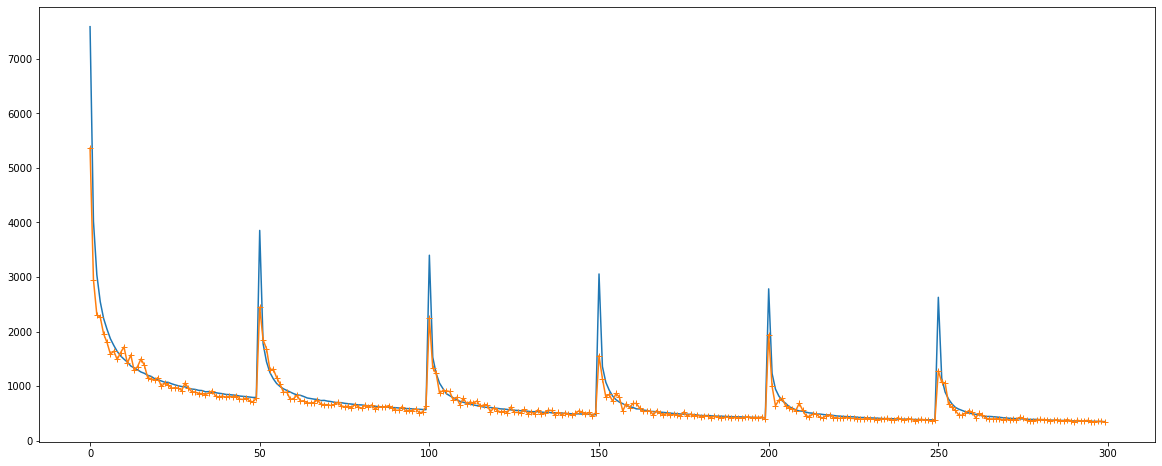

In [ ]:
mod,l1,l2 = history1
plt.plot(loss1,label='train_loss')
plt.plot(loss2, marker = '+',label='val_loss')

(352, 10)


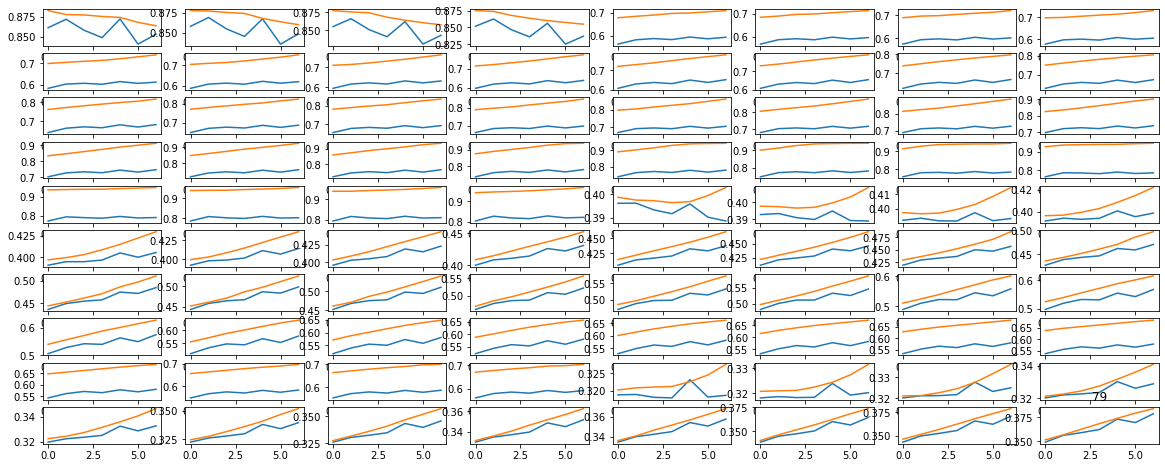

In [ ]:

plot_data(mod2,test_dataloader,random_range = 60, randomized = False)

In [ ]:
mod2 = mod


In [ ]:
EPOCHS = 40
LEARNING_RATE = 1e-3
loss_fn = tradeloss_2()
#loss_fn = nn.MSELoss()
#loss_fn = nn.SmoothL1Loss()
loss12 = []
loss22 = []
for i in range(4):
  optimizer = torch.optim.Adagrad(mod2.parameters(),lr =LEARNING_RATE )
  #lr_sch= lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)
  history2 = train(mod2, train_dataloader,val_dataloader,EPOCHS , optimizer,loss_fn,scheduler=None,
          name="lstm_nov_11_4g.pth", path= path)
  mod2, l1,l2 = history2
  loss12 = loss12 + l1
  loss22 = loss22 + l2


Epoch: 1/40
		Going for validation
	Train loss:54.862769.. 	Valid Loss:32.000889..
	Validation loss decreased (inf --> 32.000889).  Saving model ...
	Epoch:1 completed in 0m 21s
Epoch: 2/40
		Going for validation
	Train loss:24.231501.. 	Valid Loss:20.998293..
	Validation loss decreased (32.000889 --> 20.998293).  Saving model ...
	Epoch:2 completed in 0m 21s
Epoch: 3/40
		Going for validation
	Train loss:19.116771.. 	Valid Loss:16.963472..
	Validation loss decreased (20.998293 --> 16.963472).  Saving model ...
	Epoch:3 completed in 0m 21s
Epoch: 4/40
		Going for validation
	Train loss:16.207794.. 	Valid Loss:20.446403..
	Epoch:4 completed in 0m 21s
Epoch: 5/40
		Going for validation
	Train loss:14.418649.. 	Valid Loss:14.007312..
	Validation loss decreased (16.963472 --> 14.007312).  Saving model ...
	Epoch:5 completed in 0m 21s
Epoch: 6/40
		Going for validation
	Train loss:12.789382.. 	Valid Loss:11.931643..
	Validation loss decreased (14.007312 --> 11.931643).  Saving model ...
	Ep

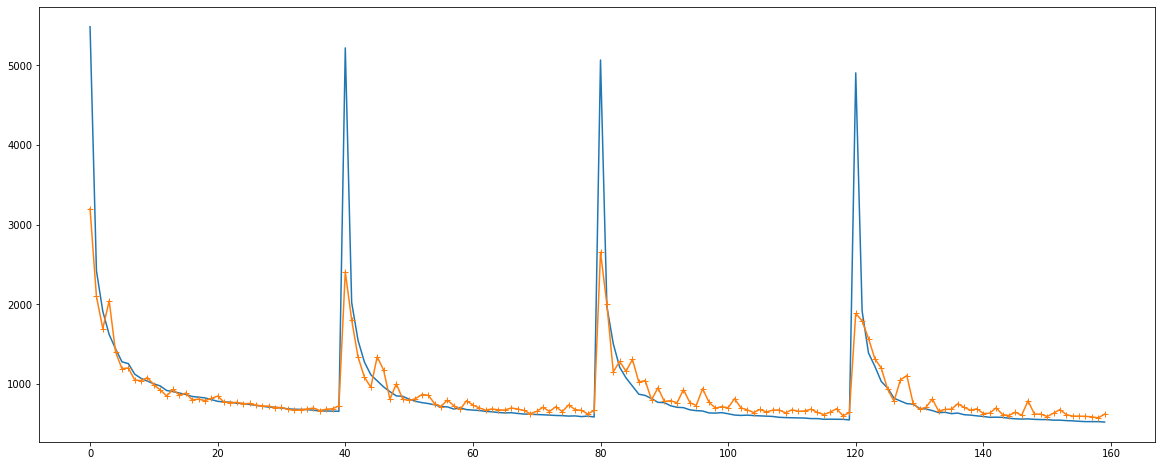

In [ ]:
mod2,l1,l2 = history2
plt.plot(loss12,label='train_loss')
plt.plot(loss22, marker = '+',label='val_loss')

In [ ]:
mod2=load_latest_model(mod,path)

(2336, 10)


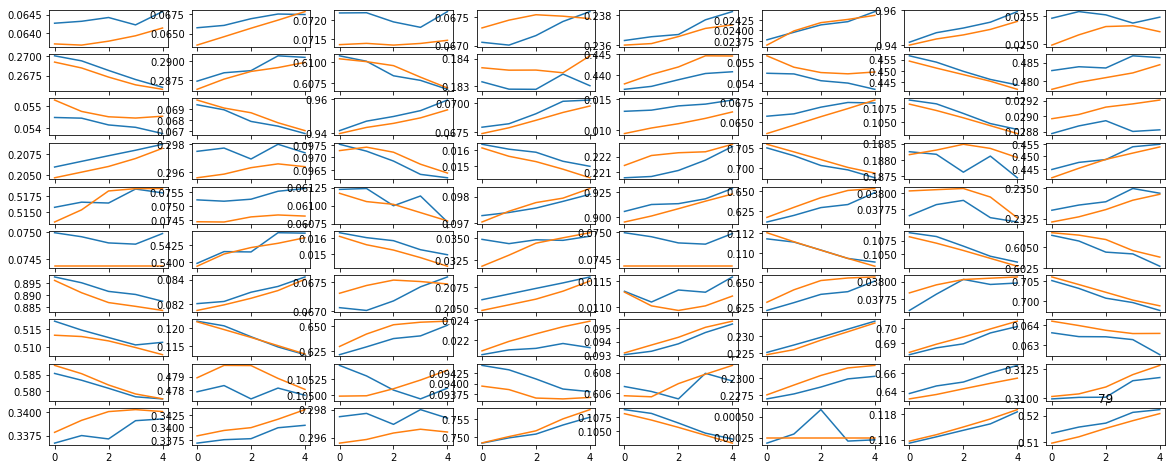

In [ ]:
plot_data(mod2,val_dataloader,random_range = 300, days=5,randomized = True)

In [ ]:
#only cpu
for inp,j in train_dataloader:
  inp = inp.float()
 


In [ ]:
def conv1(param):
  act = nn.ReLU()
  bm = nn.BatchNorm1d(num_features= (param[0]))
  conv1 = nn.Conv1d(in_channels=param[0],out_channels=param[1],kernel_size=1)
  conv21 = nn.Conv1d(in_channels=param[1],out_channels=param[2],kernel_size=3,padding=1)
  
  connection= nn.Sequential(act,bm,conv1,conv21)
  
  return connection
def conv2(param):
  act = nn.ReLU()
  bm = nn.BatchNorm1d(num_features= (param[0]))
  conv1 = nn.Conv1d(in_channels=param[0],out_channels=param[1],kernel_size=1)
  conv21 = nn.Conv1d(in_channels=param[1],out_channels=param[2],kernel_size=3,stride=2)
  
  connection= nn.Sequential(act,bm,conv1,conv21)
  
  return connection

def identity_block(con,x1,y1):
  
  y1 = con(y1)
  act = nn.ReLU()
  y1 =act(y1+x1)
  return y1,x1

def transform_block(con,con2,x1,y1):
  #print(f"y1.shape: {y1.shape}")
  y1 = con(y1)
  #print(f"y1.shape: {y1.shape}")
  y2 = con2(x1)
  #print(f"y2.shape: {y2.shape}")
  act = nn.ReLU()
  maxpool = nn.MaxPool1d(kernel_size=2,stride=1,padding=1)
  y1 =maxpool(y1)
  y1 = act(y1+y2)
  return y1,y2

In [ ]:
class identity_block(nn.Module):
  def __init__(self,param):
    super().__init__()
    self.param = param
    self.act = nn.ReLU()
    self.bm = nn.BatchNorm1d(num_features= (self.param[0]))
    self.cv1 = nn.Conv1d(in_channels=param[0],out_channels=self.param[1],kernel_size=1)
    self.cv12 = nn.Conv1d(in_channels=self.param[1],out_channels=self.param[1],kernel_size=3,padding=1)
    self.connection= nn.Sequential(self.act,self.bm,self.cv1,self.cv12)
    
  def forward(self,x,y):   #x:X y:shortcut
    y1 = self.connection(x)
    
    y1 =self.act(y1+y)
    return y1,y

In [ ]:
class transform_block(nn.Module):
  def __init__(self,param):
    super().__init__()
    self.param = param
    self.act = nn.ReLU()
    self.cond2 = nn.Conv1d(in_channels=self.param[0],out_channels=self.param[1],kernel_size=1,stride=2,dilation=2)
    self.maxpool = nn.MaxPool1d(kernel_size=2,stride=1,padding=1)
    self.bm = nn.BatchNorm1d(num_features= (self.param[0]))
    self.conv1 = nn.Conv1d(in_channels=self.param[0],out_channels=self.param[1],kernel_size=1)
    self.conv21 = nn.Conv1d(in_channels=self.param[1],out_channels=self.param[1],kernel_size=3,stride=2)
  
    self.connection= nn.Sequential(self.act,self.bm,self.conv1,self.conv21)
  
  def forward(self,x,y):   #x:X y:shortcut
    y1 = self.connection(x)
    y2 = self.cond2(y) #shortcut transform
    y1 =self.maxpool(y1)
    y1 = self.act(y1+y2)
    return y1,y2
   

In [ ]:
#identity block
class identity_block(nn.Module):
  def __init__(self,param):
    super().__init__()
    self.param = param
    self.act = nn.ReLU()
    self.bm = nn.BatchNorm1d(num_features= (self.param[0]))
    self.dropout = nn.Dropout(0.5)
    self.cv1 = nn.Conv1d(in_channels=param[0],out_channels=self.param[1],kernel_size=1)
    self.cv12 = nn.Conv1d(in_channels=self.param[1],out_channels=self.param[1],kernel_size=3,padding=1)
    self.connection= nn.Sequential(self.act,self.bm,self.cv1,self.dropout,self.cv12)
    
  def forward(self,x,y):   #x:X y:shortcut
    y1 = self.connection(x)
    
    y1 =self.act(y1+y)
    return y1,y

#transform Block
class transform_block(nn.Module):
  def __init__(self,param):
    super().__init__()
    self.param = param
    self.act = nn.ReLU()
    self.cond2 = nn.Conv1d(in_channels=self.param[0],out_channels=self.param[1],kernel_size=1,stride=2,dilation=2,bias=False)
    self.maxpool = nn.MaxPool1d(kernel_size=2,stride=1,padding=1)
    self.bm = nn.BatchNorm1d(num_features= (self.param[0]))
    self.conv1 = nn.Conv1d(in_channels=self.param[0],out_channels=self.param[1],kernel_size=1)
    self.conv21 = nn.Conv1d(in_channels=self.param[1],out_channels=self.param[1],kernel_size=3,stride=2)
  
    self.connection= nn.Sequential(self.act,self.bm,self.conv1,self.conv21)
  
  def forward(self,x,y):   #x:X y:shortcut
    y1 = self.connection(x)
    y2 = self.cond2(y) #shortcut transform
    y1 =self.maxpool(y1)
    y1 = self.act(y1+y2)
    return y1,y2
# identity + transform = Resblock   
class ResBlock(nn.Module):
  def __init__(self,batch=32,params=[]):
    super().__init__()
    self.batch = batch
   
    self.params = params
    
    self.id1 = identity_block(self.params[0])
    self.id2 = identity_block(self.params[0])
    self.id3 = identity_block(self.params[0])
    self.trf1 = transform_block(self.params[1])
    
  def forward(self,input,shortcut):
    x1, y1 = self.id1(input,shortcut)
    x1, y1  =self.id3(x1, y1 )
    x1, y1  = self.id2(x1, y1 )
    x1, y1  = self.trf1(x1, y1 )
    return x1, y1

# encoder 
class AdditiveAttention(nn.Module):

  def __init__(self, y1 =13,y2=25,y3=50,period=10, dropout=0.5,batch=32, **kwargs):
    super(AdditiveAttention, self).__init__()
    self.period = period
    self.W_y1 = nn.Linear( y1, 1024, bias=False)
    self.W_y2 = nn.Linear( y2, 1024, bias=False)
    self.W_y3 = nn.Linear( y3, 1024, bias=False)
    self.W_yn = nn.Linear( 896, 1024, bias=False)
    self.act = nn.Tanh()
    
    
    self.dropout = nn.Dropout(dropout)
  def forward(self,x,y1,y2,y3):
   
    x1 = x.broadcast_to((x.shape[0],x.shape[1],1024))
    
    y1 = self.W_y1(y1)
    y2 = self.W_y2(y2)
    y3 = self.W_y3(y3)
    yn = torch.cat((y1,y2,y3),dim=1)
    yn = self.W_yn(yn.permute(0,2,1))
    context = self.act(yn+x1)
    soft = nn.functional.softmax(context,dim=1)
    
    scores= torch.bmm(soft,x1)
    weights = torch.sum(scores,dim=1,keepdim=True).permute(0,2,1)

    return weights

class Unsam(nn.Module):
  def __init__(self,param=[],k_s=[],k=1,s=[],pad = []):
    super().__init__()
    self.param = param
    self.k_s=k_s
    self.k = k
    self.stride = s
    self.pad = pad
    self.conva1 = nn.Conv1d(in_channels=self.param[0],out_channels=self.param[0],kernel_size=self.k_s[0],stride=self.stride[0])
    self.conva2 = nn.Conv1d(in_channels=self.param[0],out_channels=self.param[0],kernel_size=self.k_s[1],stride=self.stride[1])
    self.conva3 = nn.Conv1d(in_channels=self.param[0],out_channels=self.param[0],kernel_size=self.k_s[2],stride=self.stride[2])
    self.conT1 = nn.ConvTranspose1d(in_channels=param[0],                        
                           out_channels=param[1],kernel_size = self.k,bias=False)
    self.act = nn.ReLU()
  def forward(self,out,y):
    
    out = torch.cat((out,y),dim=-1)
    y1 = self.conva1(out)
    y1 = self.conva2(y1)
    y1 = self.act(self.conva3(y1))
    y1 = self.conT1(y1)
    return y1

class Unsample(nn.Module):
  def __init__(self):
    super().__init__()

    self.unsam1 = Unsam(param=[1024,512],k_s=[2,2,2],k=[2],s=[1,1,1],pad = [0,0,0])
    self.unsam2 = Unsam(param=[512,256],k_s=[3,3,3],k=[1],s=[1,1,2],pad =[0,0,0] )
    self.unsam3 = Unsam(param=[256,128],k_s=[3,3,3],k=[1],s=[1,1,2],pad=[0,0,0])
    self.unsam4 = Unsam(param=[128,64],k_s=[3,3,3],k=[1],s=[1,1,2],pad=[0,0,0])
    
    
   
    self.conT5 = nn.ConvTranspose1d(in_channels=64,                        
                           out_channels=32,kernel_size = 3,bias=False)
    self.conT6 = nn.ConvTranspose1d(in_channels=32,                        
                           out_channels=10,kernel_size = 3,bias=False)
  def forward(self,out,y,y1,y2,y3):
    out = self.unsam1(out,y)
    print(out.shape)
    
    out = self.unsam2(out,y3)
    
    out = self.unsam3(out,y2)
    
    out = self.unsam4(out,y1)
   
    out = self.conT5(out)
    
    out = self.conT6(out)
    print(out.shape)
    
class Unsample2(nn.Module):
  def __init__(self):
    super().__init__()
    self.conT1 = nn.ConvTranspose1d(in_channels=1024,                        
                           out_channels=512,kernel_size = 3,bias=True)
    self.bn1 = nn.BatchNorm1d(512)
    
    self.act = nn.ReLU()
    
    self.conT2 = nn.ConvTranspose1d(in_channels=512,                        
                           out_channels=256,kernel_size = 3,bias=True)
    self.bn2 = nn.BatchNorm1d(256)
    self.conT3 = nn.ConvTranspose1d(in_channels=256,                        
                           out_channels=128,kernel_size = 3,bias=False)
    self.bn3 = nn.BatchNorm1d(128)
    self.conT4 = nn.ConvTranspose1d(in_channels=128,                        
                           out_channels=32,kernel_size = 3,bias=False)
    self.bn4 = nn.BatchNorm1d(32)
    self.conT5 = nn.ConvTranspose1d(in_channels=32,                        
                           out_channels=1,kernel_size = 2,bias=False)
    self.drop = nn.Dropout(0.5)
  def forward(self,out):
     out = self.act(self.bn1(self.conT1(out)))
     out = self.act(self.bn2(self.drop(self.conT2(out))))
     out = self.act(self.bn3(self.drop(self.conT3(out))))
     out = self.act(self.bn4(self.conT4(out)))
     out = self.conT5(out)
     return out.squeeze()
class CNM(nn.Module):
  def __init__(self,batch=32,features=5,pred_period=10,input_len=100,params=[64,128,256,512,1024]):
    super().__init__()
    self.batch = batch
    self.features = features
    self.pred_period = pred_period
    self.input_len = input_len
    self.params = params
    self.conv1d = nn.Conv1d(in_channels=self.features,out_channels=self.params[0],kernel_size=1)
    self.res1 = ResBlock(batch=self.batch,params=[[self.params[0],self.params[0]],[self.params[0],self.params[1]]]) 
    self.res2 = ResBlock(batch=self.batch,params=[[self.params[1],self.params[1]],[self.params[1],self.params[2]]]) 
    self.res3 = ResBlock(batch=self.batch,params=[[self.params[2],self.params[2]],[self.params[2],self.params[3]]]) 
    self.res4 = ResBlock(batch=self.batch,params=[[self.params[3],self.params[3]],[self.params[3],self.params[4]]]) 
    self.conv1d2 = nn.Conv1d(in_channels=1024,out_channels=self.params[4],kernel_size=7)

    self.dropout = nn.Dropout(0.1)
    self.act = nn.ReLU()
    self.attention = AdditiveAttention()
    self.upsample = Unsample2()
   
  def forward(self,input):
    x = input.permute(0,2,1)
    x = self.conv1d(x)
    
    x,y1 = self.res1(x,x)
    
    x,y2 = self.res2(x,y1)
    
    x,y3 = self.res3(x,y2)
    

    x,y = self.res4(x,y3)
    
    out = self.conv1d2(x)
    out = self.attention(out,y3,y2,y1)
    out = self.upsample(out)
   
    
#    out = self.act(self.dropout(self.dense(out)))
#    out = self.act(self.dropout(self.dense2(out)))
#    out = self.dense3(out)
    return out


   
mod=CNM(32)

In [ ]:
v = mod(inp)

In [ ]:
v.shape

torch.Size([32, 10])

In [ ]:
v = mod(inp)
#v = v.permute(0,2,1)

torch.Size([32, 128, 50]) torch.Size([32, 256, 25]) torch.Size([32, 512, 13]) torch.Size([32, 1024, 7])


AttributeError: ignored

In [ ]:
conT1 = nn.ConvTranspose1d(in_channels=1024,                        
                           out_channels=512,kernel_size = 2,bias=False)
conT2 = nn.ConvTranspose1d(in_channels=512,                        
                           out_channels=256,kernel_size = 2,bias=False)
conT3 = nn.ConvTranspose1d(in_channels=256,                        
                           out_channels=128,kernel_size = 3,bias=False)
conT4 = nn.ConvTranspose1d(in_channels=128,                        
                           out_channels=64,kernel_size = 3,bias=False)
conT5 = nn.ConvTranspose1d(in_channels=64,                        
                           out_channels=32,kernel_size = 3,bias=False)
conT6 = nn.ConvTranspose1d(in_channels=32,                        
                           out_channels=1,kernel_size = 2,bias=False)

In [ ]:

v1 = conT1(v)
v1 = conT2(v1)
v1 = conT3(v1)
v1 = conT4(v1)
v1 = conT5(v1)
v1 = conT6(v1)
v1 = v1.squeeze()
v1.shape

torch.Size([32, 10])

In [ ]:
cv2 = nn.Conv1d(in_channels=64,out_channels=128,kernel_size=1,stride=2,dilation=2)

In [ ]:
conv1d = nn.Conv1d(in_channels=1,out_channels=64,kernel_size=1)

con = conv1(param = [64,64,64])

In [ ]:
def conv1d_size(lin=98, pad=1, dil=1,kernel=3,stride=1):
  return ((lin + 2*pad)-(dil*(kernel-1))-1)/stride


In [ ]:
x = inp.permute(0,2,1)
x1 =x[:,0:1,:]
print(x1.shape)
y1 = conv1d(x1)
print(y1.shape)
y1,x1 = identity_block(con,y1,y1)
y1,x1 = identity_block(con,x1,y1)
y1,x1 = identity_block(con,x1,y1)
print(y1.shape)

torch.Size([32, 1, 100])
torch.Size([32, 64, 100])


TypeError: ignored

In [ ]:
conv1d_size(lin=100, pad=1, dil=1,kernel=1,stride=2)+1


51.5

In [ ]:
con1 = conv2(param = [64,128,128])

con3 = conv1(param = [128,128,128])
cond2 = nn.Conv1d(in_channels=64,out_channels=128,kernel_size=1,stride=2,dilation=2)

y2,y3 = transform_block(con1,cond2,y1,y1)

y2,y3 = identity_block(con3,y2,y3)
y2,y3 = identity_block(con3,y2,y3)
print(y1.shape)
print(y2.shape)
print(y3.shape)

cond3 = nn.Conv1d(in_channels=128,out_channels=256,kernel_size=1,stride=2,dilation=2)
con4 = conv2(param = [128,256,256])
con5 = conv1(param = [256,256,256])

y2,y3 = transform_block(con4,cond3,y2,y3)

y2,y3 = identity_block(con5,y2,y3)
y2,y3 = identity_block(con5,y2,y3)


print(y2.shape)
print(y3.shape)

cond4 = nn.Conv1d(in_channels=256,out_channels=512,kernel_size=1,stride=2,dilation=2)
con6 = conv2(param = [256,512,512])
con7 = conv1(param = [512,512,512])

y2,y3 = transform_block(con6,cond4,y2,y3)

y2,y3 = identity_block(con7,y2,y3)
y2,y3 = identity_block(con7,y2,y3)

print(y2.shape)
print(y3.shape)

cond5 = nn.Conv1d(in_channels=512,out_channels=1024,kernel_size=1,stride=2,dilation=2)
con8 = conv2(param = [512,1024,1024])
con9 = conv1(param = [1024,1024,1024])

y2,y3 = transform_block(con8,cond5,y2,y3)

y2,y3 = identity_block(con9,y2,y3)
y2,y3 = identity_block(con9,y2,y3)

print(y2.shape)
print(y3.shape)
cond11 = nn.Conv1d(in_channels=1024,out_channels=1024,kernel_size=7)
con11 = conv2(param = [1024,512,512])
cond12 = nn.Conv1d(in_channels=512,out_channels=256,kernel_size=1,stride=2,dilation=2)
con12 = conv2(param = [512,256,256])
y2 = cond11(y2)
print(y2.shape)

torch.Size([32, 64, 100])
torch.Size([32, 128, 50])
torch.Size([32, 128, 50])
torch.Size([32, 256, 25])
torch.Size([32, 256, 25])
torch.Size([32, 512, 13])
torch.Size([32, 512, 13])
torch.Size([32, 1024, 7])
torch.Size([32, 1024, 7])
torch.Size([32, 1024, 1])


In [ ]:
conT1 = nn.ConvTranspose1d(in_channels=)  #[32,1024,1]->#[32,10,1]

In [ ]:
x1 = y2.squeeze()
x1 = x1.permute(0,2,1)


RuntimeError: ignored

In [ ]:
x = inp
x1 = inp.permute(0,2,1)
y1 = conv1(x1)
y1 = pool12(y1)
y1= conv12(y1)
y1 = pool13(y1)
y1 = conv123(y1)
y2 = conv2(x)
y2 = conv21(y2)
y2 = pool23(y2)
print(y1.shape,y2.shape)


y1

z = convT1(y1)
z = convT2(z)
z = convT3(z)
print(z.shape)

torch.Size([32, 128, 1]) torch.Size([32, 512, 1])
torch.Size([32, 1, 10])


In [ ]:
train_dataloader , val_dataloader, test_dataloader = prepare(['TRIVENI'],min_max=True, batch =32, shuffle = False)

[*********************100%***********************]  1 of 1 completed
Index(['Adj Close', 'Volume', 'd_cma', 'dd_cma', 'Adj Close MA'], dtype='object')
(3771, 100, 5)
len x_train (3040, 100, 5), y_train 3040; x_val(320, 100, 5); y val 320 ; x test (352, 100, 5) y test 352


In [ ]:
train_dataloader , val_dataloader, test_dataloader = prepare(['TATAMOTORS','ONGC','BPCL','INDUSINDBK','LT','IOC','ULTRACEMCO','TECHM'],min_max=True, batch =32, shuffle = True)

[*********************100%***********************]  1 of 1 completed
Index(['Adj Close', 'Volume', 'd_cma', 'dd_cma', 'Adj Close MA'], dtype='object')
[*********************100%***********************]  1 of 1 completed
Index(['Adj Close', 'Volume', 'd_cma', 'dd_cma', 'Adj Close MA'], dtype='object')
[*********************100%***********************]  1 of 1 completed
Index(['Adj Close', 'Volume', 'd_cma', 'dd_cma', 'Adj Close MA'], dtype='object')
[*********************100%***********************]  1 of 1 completed
Index(['Adj Close', 'Volume', 'd_cma', 'dd_cma', 'Adj Close MA'], dtype='object')
[*********************100%***********************]  1 of 1 completed
Index(['Adj Close', 'Volume', 'd_cma', 'dd_cma', 'Adj Close MA'], dtype='object')
[*********************100%***********************]  1 of 1 completed
Index(['Adj Close', 'Volume', 'd_cma', 'dd_cma', 'Adj Close MA'], dtype='object')
[*********************100%***********************]  1 of 1 completed
Index(['Adj Close', 'Volu

In [ ]:
data = StockData('TRIVENI',min_max=True)

[*********************100%***********************]  1 of 1 completed
Index(['Adj Close', 'Volume', 'd_cma', 'dd_cma', 'Adj Close MA'], dtype='object')


In [ ]:
df = data.data

In [ ]:
df2 = df["Adj Close MA"]

In [ ]:
df2 = df2.to_numpy()

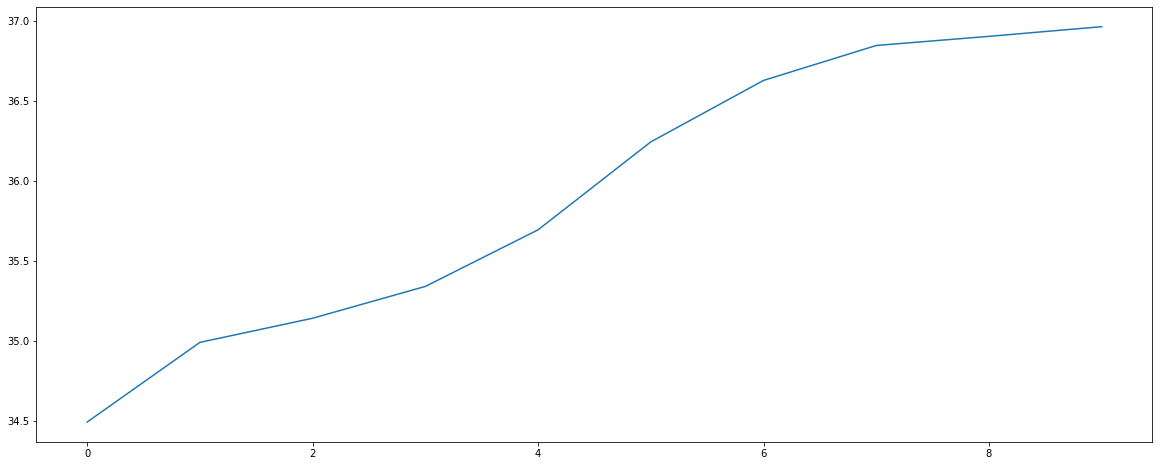

In [ ]:
plt.plot(df2[110:120])

In [ ]:
x = df.to_numpy()


In [ ]:
xc = x[10:110].
sc = MinMaxScaler()
sc.fit(x)
sc.transform(xc)

ValueError: ignored

In [ ]:
x = torch.tensor(xc,dtype=torch.float32).unsqueeze(0)
x = x.broadcast_to([32,x.shape[1],x.shape[2]])

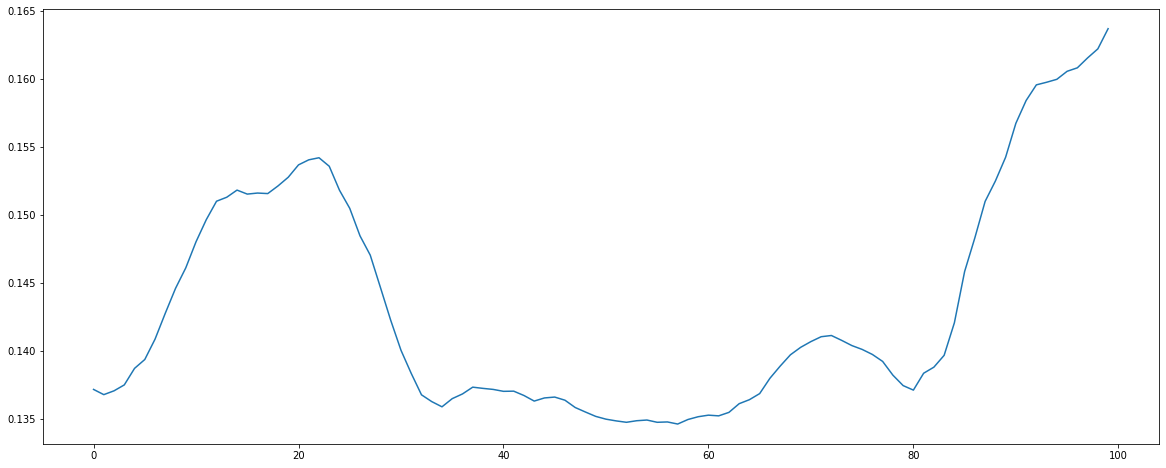

In [ ]:
plt.plot(inp[10,:,-1])

In [ ]:
out = mod(inp)
out

tensor([[0.1537, 0.1545, 0.1562, 0.1569, 0.1580, 0.1588, 0.1604, 0.1596, 0.1626,
         0.0849],
        [0.1560, 0.1564, 0.1577, 0.1581, 0.1587, 0.1591, 0.1605, 0.1594, 0.1620,
         0.0849],
        [0.1567, 0.1570, 0.1579, 0.1582, 0.1586, 0.1586, 0.1599, 0.1585, 0.1609,
         0.0845],
        [0.1574, 0.1575, 0.1582, 0.1583, 0.1587, 0.1585, 0.1597, 0.1582, 0.1603,
         0.0845],
        [0.1587, 0.1586, 0.1592, 0.1594, 0.1596, 0.1594, 0.1606, 0.1591, 0.1610,
         0.0848],
        [0.1587, 0.1586, 0.1591, 0.1595, 0.1597, 0.1597, 0.1609, 0.1595, 0.1614,
         0.0847],
        [0.1598, 0.1597, 0.1604, 0.1609, 0.1612, 0.1613, 0.1626, 0.1613, 0.1631,
         0.0853],
        [0.1604, 0.1604, 0.1612, 0.1616, 0.1620, 0.1621, 0.1634, 0.1622, 0.1639,
         0.0856],
        [0.1616, 0.1617, 0.1625, 0.1631, 0.1635, 0.1638, 0.1649, 0.1638, 0.1657,
         0.0865],
        [0.1620, 0.1622, 0.1629, 0.1635, 0.1641, 0.1643, 0.1654, 0.1643, 0.1662,
         0.0868],
        [0

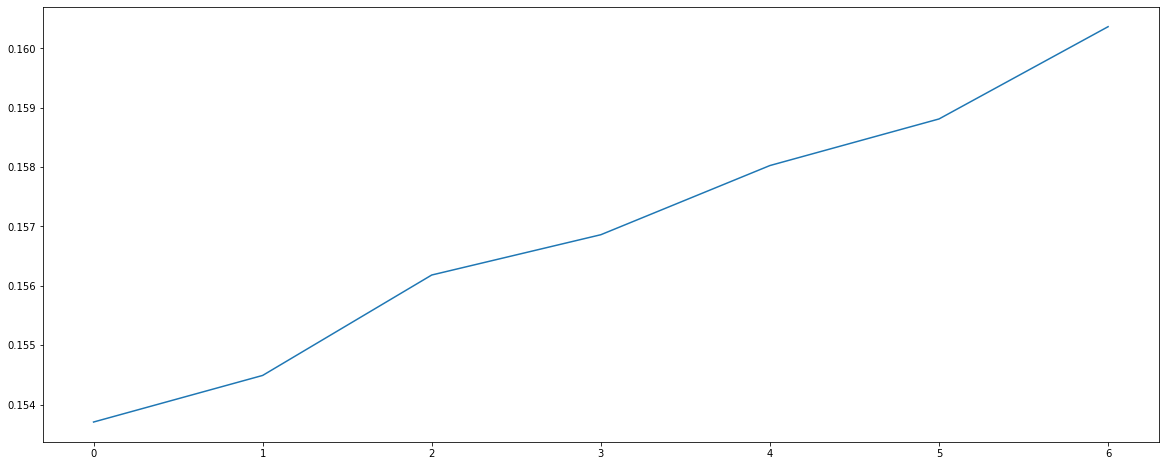

In [ ]:
plt.plot(out[0][0:7].detach().numpy())

In [ ]:
 train_dataloader , val_dataloader, test_dataloader = prepare(['TRIVENI','ADANIPORTS','JSWSTEEL','SBILIFE','UPL','TCS','BAJAJ-AUTO'],min_max=True, batch =32, shuffle = True)

[*********************100%***********************]  1 of 1 completed
Index(['Adj Close', 'Volume', 'd_cma', 'dd_cma', 'Adj Close MA'], dtype='object')
[*********************100%***********************]  1 of 1 completed
Index(['Adj Close', 'Volume', 'd_cma', 'dd_cma', 'Adj Close MA'], dtype='object')
[*********************100%***********************]  1 of 1 completed
Index(['Adj Close', 'Volume', 'd_cma', 'dd_cma', 'Adj Close MA'], dtype='object')
[*********************100%***********************]  1 of 1 completed
Index(['Adj Close', 'Volume', 'd_cma', 'dd_cma', 'Adj Close MA'], dtype='object')
[*********************100%***********************]  1 of 1 completed
Index(['Adj Close', 'Volume', 'd_cma', 'dd_cma', 'Adj Close MA'], dtype='object')
[*********************100%***********************]  1 of 1 completed
Index(['Adj Close', 'Volume', 'd_cma', 'dd_cma', 'Adj Close MA'], dtype='object')
[*********************100%***********************]  1 of 1 completed
Index(['Adj Close', 'Volu

In [ ]:
'TRIVENI','ADANIPORTS','JSWSTEEL','SBILIFE','UPL','TCS',

In [ ]:
batch =32
model = LSTM(batch)
train_dataloader , val_dataloader, test_dataloader = prepare(['TCS'],min_max=True, batch =batch, shuffle = True)


[*********************100%***********************]  1 of 1 completed
Index(['Adj Close', 'Volume', 'd_cma', 'dd_cma', 'Adj Close MA'], dtype='object')
(4627, 100, 5)
len x_train (3744, 100, 5), y_train 3744; x_val(416, 100, 5); y val 416 ; x test (448, 100, 5) y test 448


In [ ]:
model = load_latest_model(model, name="lstm_nov_11_4d.pth", path=path)

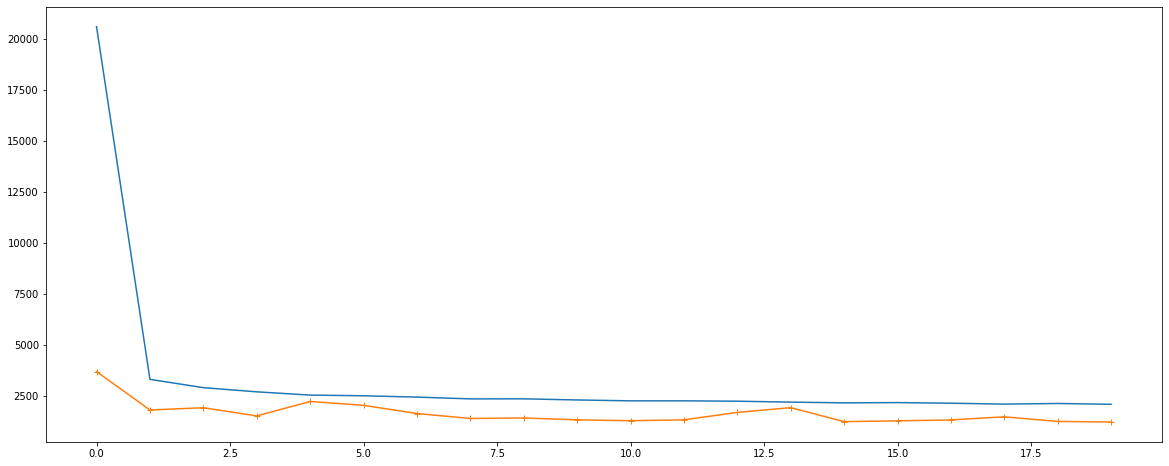

In [ ]:
model,l1,l2 = history1
plt.plot(l1,label='train_loss')
plt.plot(l2, marker = '+',label='val_loss')

<module 'numpy' from '/usr/local/lib/python3.7/dist-packages/numpy/__init__.py'>

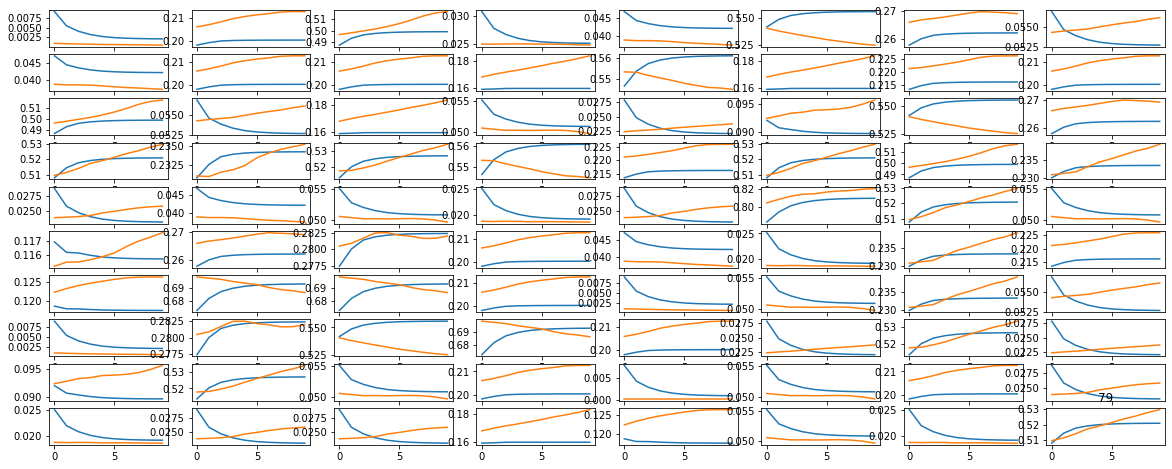

In [ ]:
#lstm2_1mo
plot_data(model,val_dataloader,random_range = 28, randomized = True)

(352, 10)
[178, 179, 180, 181]
[0.32218453 0.32221082 0.32264474 0.32267106 0.32264474 0.32348633
 0.32372299 0.32388079 0.3236441  0.32349947]


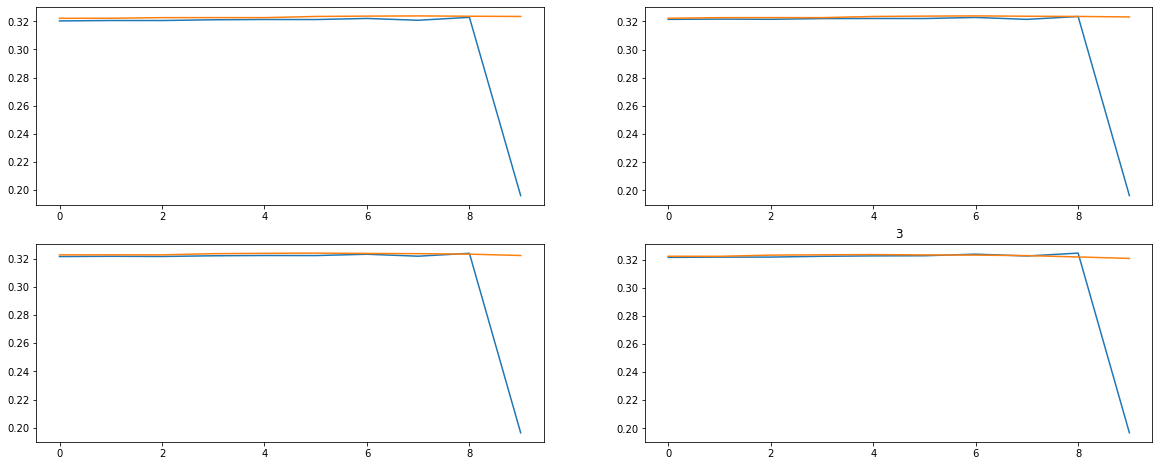

In [ ]:
#2nd mo
plot_data(mod2,test_dataloader,random_range = 178,row=2,col=2,randomized=False)

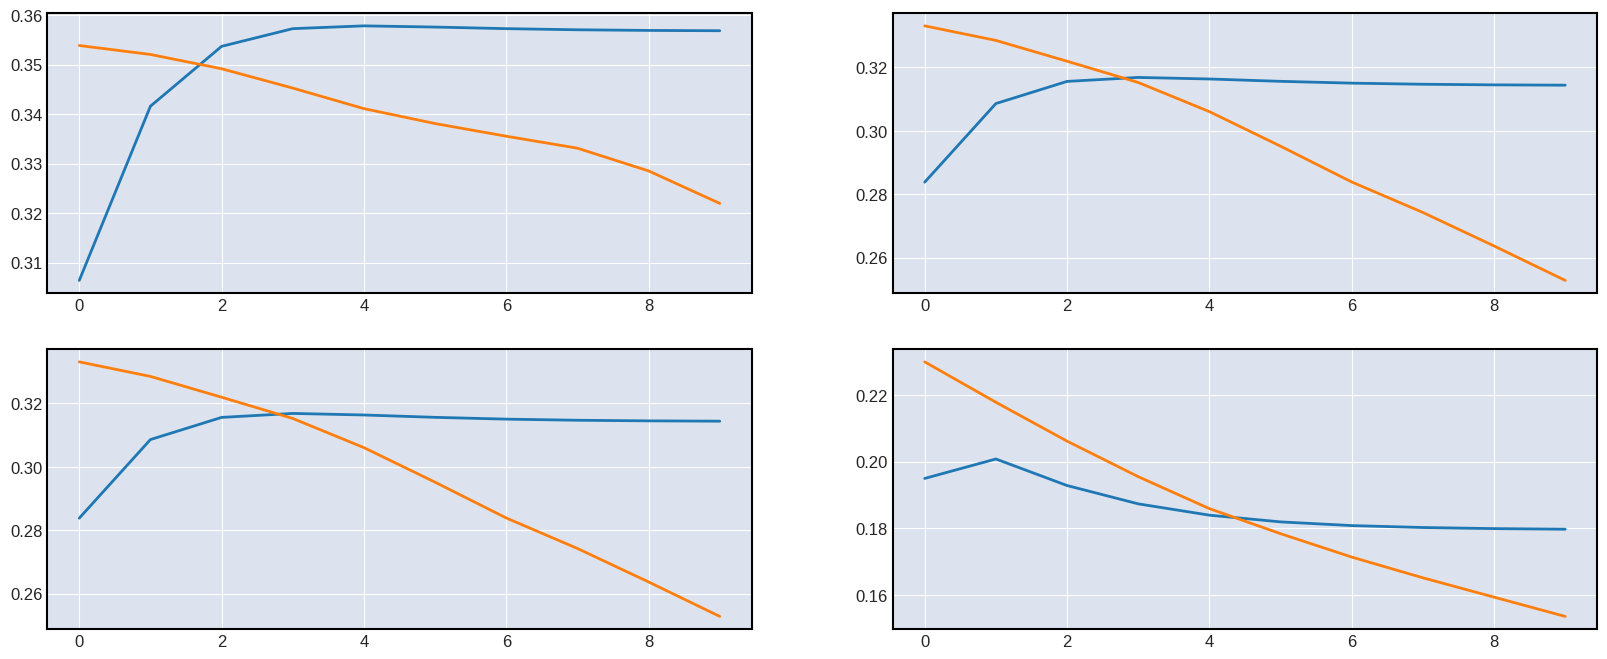

In [ ]:
#1st mo
#plot_data(model,val_dataloader)

In [ ]:
#loss = tradeloss()
pred = model(input)
pred = pred.cpu()
pred,target = pred.squeeze(),target.squeeze()
y_true_next = target[:,1:]
y_pred_next = pred[:,1:]
y_true_tdy = target[:,:-1]
y_pred_tdy = pred[:,:-1]


y_true_diff = y_true_next - y_true_tdy
y_pred_diff = y_pred_next - y_pred_tdy
print(y_pred_diff.shape)
standard = torch.zeros_like(y_pred_diff)
y_true_move = torch.gt(y_true_diff,standard)
y_pred_move = torch.gt(y_pred_diff,standard)

condition = torch.ne(y_true_move,y_pred_move)

print(condition.shape)
print(condition[0:2])
alpha =1000*torch.ones_like(y_pred_tdy,dtype=torch.float32,device='cpu')
ones = torch.ones_like(y_pred_tdy,dtype=torch.float32,device='cpu')
indexes = torch.where(y_true_move != y_pred_move,alpha,ones)
ones = torch.ones((pred.shape[0],1),device='cpu')
indexes = torch.cat([indexes,ones],dim=1)
indexes = indexes.to('cpu')
diff = torch.square(pred - target) * indexes
loss = torch.mean(diff, 1)
loss_ovrall = torch.mean(loss)

break

ones = torch.ones_like(indices)
 
indices = torch.add(indices,ones)
indices =torch.LongTensor(indices.tolist())
direction_loss = Variable(torch.ones_like(pred))

indices = indices.to('cpu')
print(indices.shape)
direction_loss = direction_loss.index_put_(tuple(indices.t()),alpha)
loss = torch.mean((direction_loss * torch.square(y_true - y_pred)),dim=1)

torch.Size([64, 9])
torch.Size([64, 9])
tensor([[ True,  True,  True, False,  True,  True, False,  True,  True],
        [False, False,  True,  True, False, False,  True, False, False]])
torch.Size([64])


SyntaxError: ignored

In [ ]:
class LSTMensembledLSTM(nn.Module):
  def __init__(self,models,dense=256,batch=64,pred_period=10,input_features=5,lstm_hid=64,lookout_days=100):
    super(LSTMensembledLSTM,self).__init__()
    self.models = models
    self.num_hidden=lstm_hid
    self.device = ('cuda' if torch.cuda.is_available() else 'cpu')
    self.freeze_parameters_of_children()

    self.batch = batch
    self.period = pred_period 
    self.input_size = input_features
    self.hidden_size = lstm_hid
    self.dense_neurons = dense
    self.enc_seq_len = lookout_days

    self.lstm = nn.LSTM(input_size=len(self.models),hidden_size=self.num_hidden,num_layers=1,batch_first=True,bidirectional=False,bias = True)
    self.dense = nn.Linear(in_features=self.num_hidden, out_features=dense)
    self.dense1 = nn.Linear(in_features=dense, out_features=dense)
    self.dense2 = nn.Linear(in_features=dense, out_features = 1)
    
    

    #self.lstm_enc = nn.LSTM(input_size=self.input_size,hidden_size=self.hidden_size ,num_layers=1,batch_first=True)
    #self.lstm_cell = nn.LSTMCell(input_size=self.hidden_size,hidden_size=self.hidden_size)
    self.act1 = nn.ReLU6()
    #self.attention = AdditiveAttention(hidden_state=self.hidden_size,num_hiddens=dense, period=self.enc_seq_len, dropout=0.5, batch=batch)
    #self.dense1 = nn.Linear(in_features=self.hidden_size, out_features=self.dense_neurons)
    #self.dense = nn.Linear(in_features=self.dense_neurons, out_features=1)
    self.dropout = nn.Dropout(0.6)
  def forward(self, inputs):

    predictions = torch.empty([inputs.shape[0],10,0],dtype=torch.float32,device=self.device)
    for i,model in enumerate(self.models):
        out = model(inputs)
        
        predictions = torch.cat([predictions,out.unsqueeze(-1)],dim=-1)
        
    
    x,hidden = self.lstm(predictions)
    
    x = self.act1(self.dropout(self.dense(x)))
    
    #x = self.act1(self.dropout(self.dense1(x)))
    
    x = self.dense2(x)
    
    return x
  
  def freeze_parameters_of_children(self):
    models = []
    for model in self.models:
      for params in model.parameters():
        params.require_grad = False
      models.append(model.to(self.device))
    self.models = models
    return 
ens = LSTMensembledLSTM([m1,m2],10)

In [ ]:
for inp,tar in train_dataloader:
  inp = inp.float()
  out = ens(inp)
  break

torch.Size([32, 10, 64])


In [ ]:
m1 = load_latest_model(mod, name="/content/lstm_nov_11_4f.pth")
m2 = load_latest_model(mod, name="/content/lstm_nov_11_4g.pth")

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/rnn.py:65: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


In [ ]:
batch = 32
loss = tradeloss_2()
shuffle = True
device = device


MODELS = []
LOSSES = []



In [ ]:
tickers = ['TATAMOTORS','ONGC','BPCL','INDUSINDBK','LT','IOC','ULTRACEMCO','TECHM']
EPOCHS_1 = 30
set_n ='b'
for i,ticker in enumerate(tickers):
  print('Downloading : '+ticker)
  train_dataloader , val_dataloader, test_dataloader = prepare([ticker],min_max=True, batch =batch, shuffle = shuffle)
  model = LSTM(64,)
  model.cuda()
  model_name=f"STLM{i}_{ticker}_{set_n}.pth"
  LEARNING_RATE = 1e-3
  loss_fn = tradeloss()

  optimizer = torch.optim.Adam(model.parameters(),lr =LEARNING_RATE )
  lr_sch= lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)
  history1 = train(model, train_dataloader,val_dataloader,EPOCHS_1 , optimizer,loss_fn,scheduler=None,
          name=model_name, path=path)
  model,l1,l2 =history1
  MODELS.append(model)
  LOSSES.append([l1,l2])
  


In [ ]:
for i, model in enumerate(MODELS):
  MODELS[i].train()

In [ ]:
MODELS = MODELS[1:]

In [ ]:
tickers = ['TRIVENI', 'SBILIFE','UPL','TCS','BAJAJ-AUTO']

In [ ]:
train_dataloader , val_dataloader, test_dataloader = prepare(tickers,min_max=True, batch =batch, shuffle = True)




[*********************100%***********************]  1 of 1 completed
Index(['Adj Close', 'Volume', 'd_cma', 'dd_cma', 'Adj Close MA'], dtype='object')
[*********************100%***********************]  1 of 1 completed
Index(['Adj Close', 'Volume', 'd_cma', 'dd_cma', 'Adj Close MA'], dtype='object')
[*********************100%***********************]  1 of 1 completed
Index(['Adj Close', 'Volume', 'd_cma', 'dd_cma', 'Adj Close MA'], dtype='object')
[*********************100%***********************]  1 of 1 completed
Index(['Adj Close', 'Volume', 'd_cma', 'dd_cma', 'Adj Close MA'], dtype='object')
[*********************100%***********************]  1 of 1 completed
Index(['Adj Close', 'Volume', 'd_cma', 'dd_cma', 'Adj Close MA'], dtype='object')
[*********************100%***********************]  1 of 1 completed
Index(['Adj Close', 'Volume', 'd_cma', 'dd_cma', 'Adj Close MA'], dtype='object')
[*********************100%***********************]  1 of 1 completed
Index(['Adj Close', 'Volu

In [ ]:
EPOCHS_2=30
  #ens = LSTMensembledLSTM(MODELS)
  #ens.cuda()
L1=[]
L2=[]
for i in range(4):
  model_name_2=f"STCDLMEN_k_.pth"
  LEARNING_RATE = 1e-3
  loss_fn = tradeloss()

  optimizer = torch.optim.Adagrad(ens.parameters(),lr =LEARNING_RATE )
  lr_sch= lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

  history3 = train(ens, train_dataloader,val_dataloader,EPOCHS_2 , optimizer,loss_fn,scheduler=None,
          name=model_name_2, path=path)
  ensembled,l1,l2 = history3
  L1 = L1+l1
  L2 = L2+l2

Epoch: 1/30
		Going for validation
	Train loss:542.783226.. 	Valid Loss:318.066763..
	Validation loss decreased (inf --> 318.066763).  Saving model ...
	Epoch:1 completed in 0m 45s
Epoch: 2/30
		Going for validation
	Train loss:449.815389.. 	Valid Loss:275.322087..
	Validation loss decreased (318.066763 --> 275.322087).  Saving model ...
	Epoch:2 completed in 0m 45s
Epoch: 3/30
		Going for validation
	Train loss:422.561810.. 	Valid Loss:259.532897..
	Validation loss decreased (275.322087 --> 259.532897).  Saving model ...
	Epoch:3 completed in 0m 45s
Epoch: 4/30
		Going for validation
	Train loss:403.964821.. 	Valid Loss:261.947090..
	Epoch:4 completed in 0m 45s
Epoch: 5/30
		Going for validation
	Train loss:392.065767.. 	Valid Loss:250.700564..
	Validation loss decreased (259.532897 --> 250.700564).  Saving model ...
	Epoch:5 completed in 0m 45s
Epoch: 6/30
		Going for validation
	Train loss:382.008567.. 	Valid Loss:235.748399..
	Validation loss decreased (250.700564 --> 235.748399). 

(2624, 10)


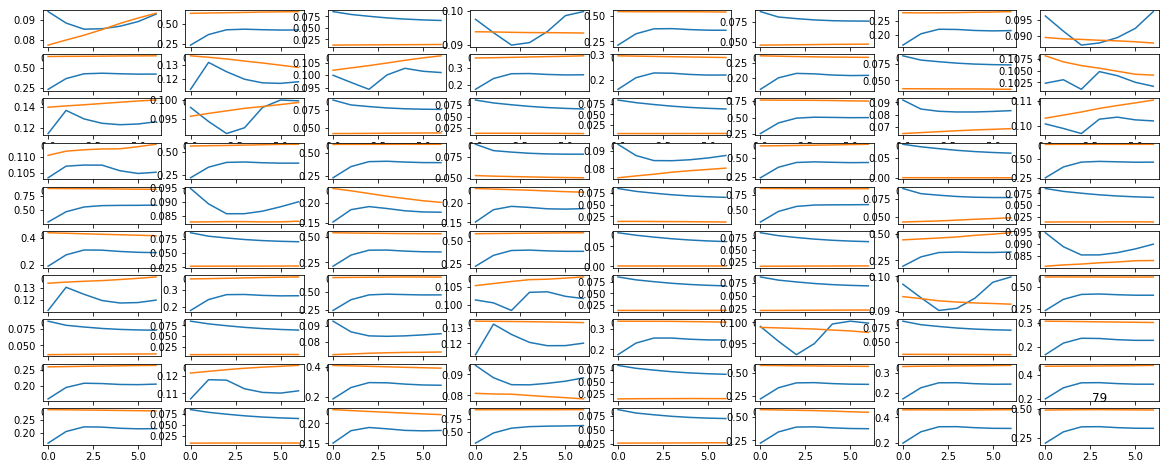

In [ ]:
# tickers = ['TATAMOTORS','ONGC','BPCL','INDUSINDBK','LT','IOC','ULTRACEMCO','TECHM'] "STLMEN_b_.pth"
plot_data(ensembled,test_dataloader,random_range = 120)

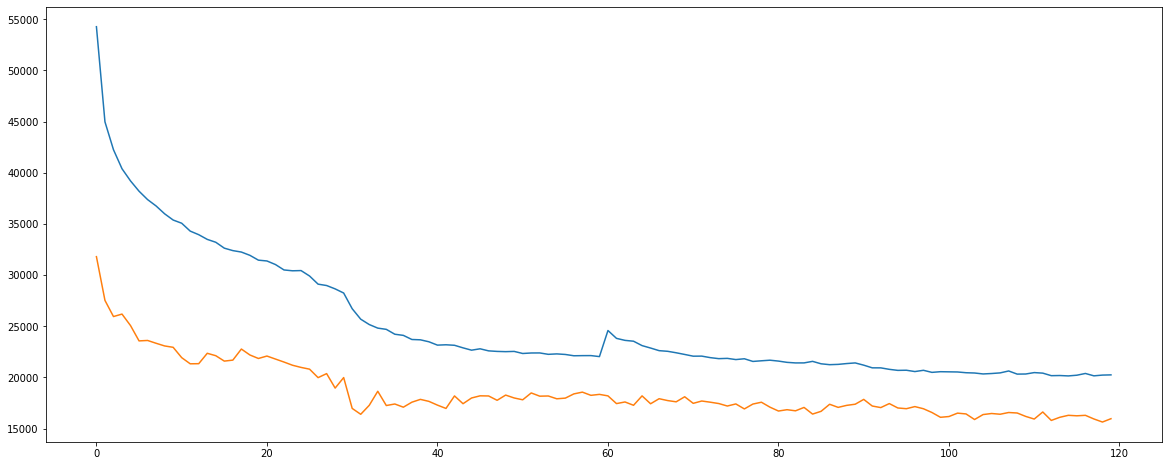

In [ ]:
plt.plot(L1)
plt.plot(L2)

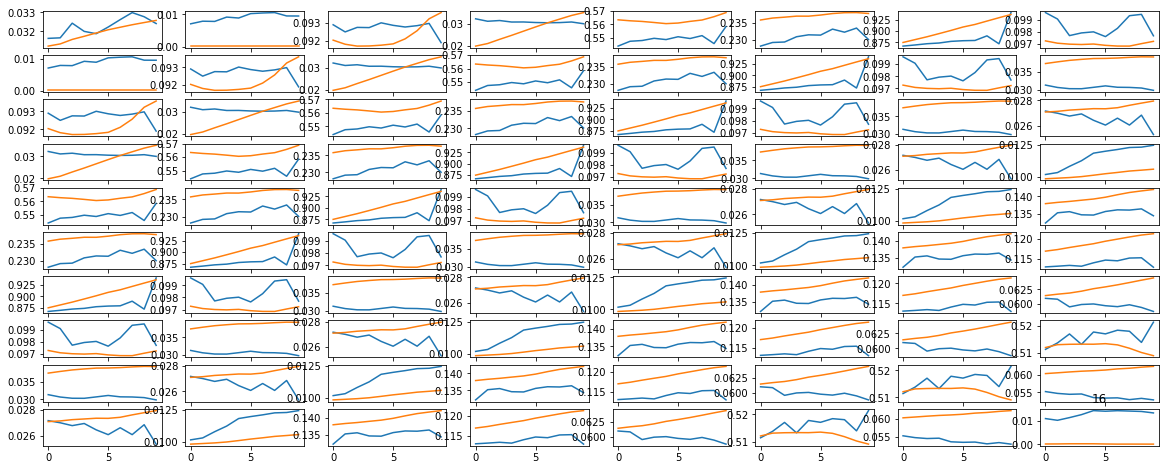

In [ ]:
plot_data(ensembled,test_dataloader,random_range = 120)

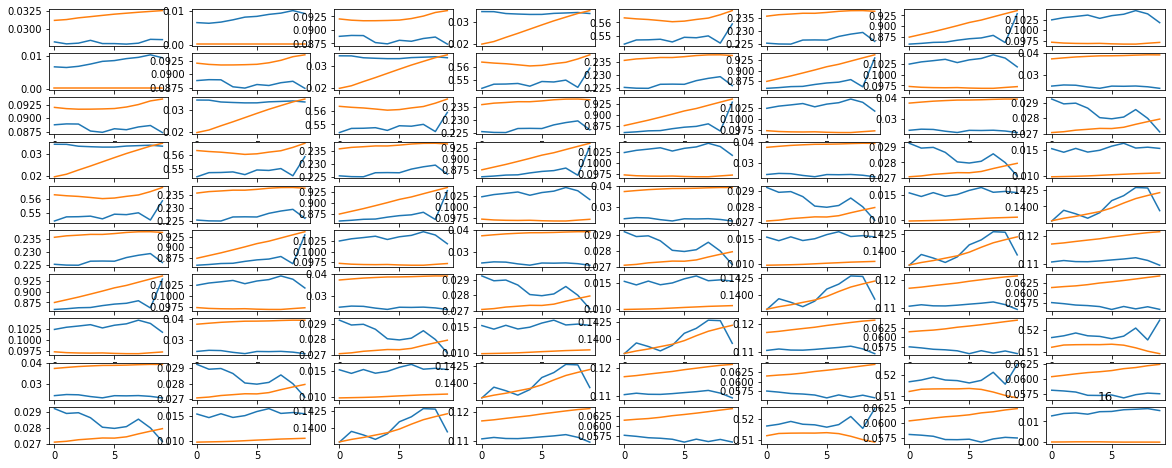

In [ ]:
plot_data(ens,test_dataloader,random_range = 120)

In [ ]:
ens(input)

torch.Size([64, 10, 3])
torch.Size([64, 10, 1])


In [ ]:
print(out.shape)

torch.Size([32, 10, 1])


In [ ]:
for i,child in enumerate(model.children()):
  print(i, '    ', child)
  if i<4:
    for param in child.parameters():
      print(param.shape)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
for inp,tar in train_dataloader:
  break

In [ ]:
batch = 32
lstm_hidden_size = 64
lstm = nn.LSTMCell(input_size=64,hidden_size=64)
lstm_2 = nn.LSTM(input_size=5,hidden_size=64,num_layers=1,batch_first=True)
lstm_3 = nn.LSTM(input_size =64, hidden_size=64,num_layers=1)

conv2d = nn.Conv2d(in_channels=1,out_channels=32, kernel_size=(8,1))
conv1d_1 = nn.Conv1d(in_channels = 1, out_channels= 32, kernel_size=2)
conv1d_2 = nn.Conv1d(in_channels = 32, out_channels= 64, kernel_size=2)
conv1d_2_2 = nn.Conv1d(in_channels = 64, out_channels= 64, kernel_size=2)
conv1d_3 = nn.Conv1d(in_channels = 64, out_channels= 128, kernel_size=2)
conv1d_4 = nn.Conv1d(in_channels = 128, out_channels= 128, kernel_size=2)
maxPool2d = nn.MaxPool2d(kernel_size=1)


act1 = nn.ReLU()

dense = nn.Linear(in_features=64, out_features=1)

print(inp.shape)
out1, hidden1 = lstm_2(inp)
hx,cx=hidden1
print(hx.shape)
print(out1.shape)
hx2 = torch.randn(32,64)
cx2 = torch.randn(32,64)
output = torch.empty((10,32,64))
for i in range(10):
  out,hid = lstm(hx[0],(hx2,cx2))
  output[i] = out
print(output.shape)

torch.Size([32, 100, 5])
torch.Size([1, 32, 64])
torch.Size([32, 100, 64])
torch.Size([10, 32, 64])


In [ ]:
out , hid =out2
print(out.shape)

torch.Size([1, 100, 64])


In [ ]:
df = data.dataframe_out()

In [ ]:
dataset = df.to_numpy()

In [ ]:
step_size = 100
pred_period = 10
data_X, data_Y = [], []
for i in range(dataset.shape[0]-step_size-pred_period-1):
    x = dataset[i:(i+step_size),:-1]
    data_X.append(x)
    y = dataset[i+step_size:i+step_size + pred_period, 4:]
    data_Y.append(y)
x,y=np.array(data_X), np.array(data_Y)

In [ ]:
print(x.shape)
print(y.shape)

(3766, 100, 4)
(3766, 10, 1)


In [ ]:
dataset[(step_size):(step_size + pred_period), -1:].shape

(10, 1)

array([[ 4.11867676e+01,  1.97711400e+06,  4.87105347e+01,
        -2.84715538e+00]])

In [ ]:
min_max_data = MinMaxScaler()
min_max_y = MinMaxScaler()
min_max_data.fit(dataset[:,-1].reshape(-1,1))
nddata = min_max_data.transform(y[0])

In [ ]:
print(nddata)

[[0.14278552]
 [0.14054769]
 [0.13796707]
 [0.1351932 ]
 [0.13222977]
 [0.12957599]
 [0.12748526]
 [0.12632253]
 [0.12583517]
 [0.12585706]]


In [ ]:
data = yf.download("TRIVENI.NS")

[*********************100%***********************]  1 of 1 completed


In [ ]:
df = data.copy()
df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2005-12-13,28.891199,37.110485,28.671286,35.653553,30.868689,69641411.0
2005-12-14,37.385376,38.704861,35.653553,36.890572,31.939688,24896632.0
2005-12-15,37.110485,37.495335,35.186237,36.285805,31.416084,10544835.0
2005-12-16,36.285805,37.110485,34.663940,35.268703,30.535482,5086494.0
2005-12-19,35.736019,38.210052,35.461128,37.522823,32.487099,11410756.0


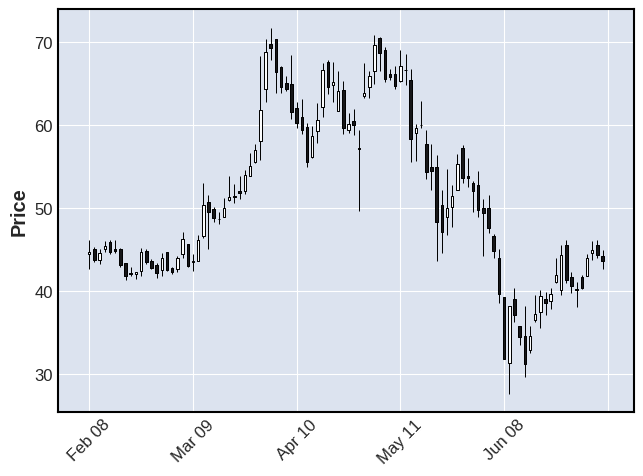

AttributeError: ignored

In [ ]:
df.index

DatetimeIndex(['2006-02-08', '2006-02-10', '2006-02-13', '2006-02-14',
               '2006-02-15', '2006-02-16', '2006-02-17', '2006-02-20',
               '2006-02-21', '2006-02-22',
               ...
               '2021-10-20', '2021-10-21', '2021-10-22', '2021-10-25',
               '2021-10-26', '2021-10-27', '2021-10-28', '2021-10-29',
               '2021-11-01', '2021-11-02'],
              dtype='datetime64[ns]', name='Date', length=3872, freq=None)

In [ ]:
import plotly.graph_objects as go

In [ ]:
fig = go.Figure(data=go.Ohlc(x=df.index,
                open=df['Open'],
                high=df['High'],
                low=df['Low'],
                close=df['Adj Close']))
fig.update(layout_xaxis_rangeslider_visible=False)
fig.show()

In [ ]:
df2 = df.copy()


In [ ]:
df2['Adj Close MA'] = df2['Adj Close'].rolling(20).mean()
df2.index[-1]

Timestamp('2021-11-09 00:00:00')

In [ ]:
d_close = 10*(df['Adj Close MA'].shift(-3)- df['Adj Close MA']).rolling(10).mean()
d_dma = df['Adj Close MA'] + (d_close)

In [ ]:
d_aca = d_dma- d_dma.shift(-3)

In [ ]:

df2['Adj Close MA'] = df2['Adj Close'].rolling(20).mean()
df2['d_close'] = 10*(df2['Adj Close MA']- df2['Adj Close MA'].shift(3)).rolling(10).mean()
df2['d_dma'] = df2['Adj Close MA'] + df2['d_close']
df2['d_aca'] = df2['d_dma'] - df2['d_dma'].shift(3)

In [ ]:
df2.tail()

,Open,High,Low,Close,Adj Close,Volume,Adj Close MA,d_close,d_dma,d_aca
Date,,,,,,,,,,
2021-11-02,196.000000,206.500000,194.550003,204.050003,202.808212,988812.0,198.352992,31.362965,229.715957,-10.090714
2021-11-03,205.300003,207.699997,198.500000,201.149994,199.925858,592128.0,198.422566,26.102674,224.525240,-13.522201
2021-11-04,203.800003,206.300003,201.250000,203.399994,202.162170,237791.0,198.862373,21.200191,220.062565,-14.297456
2021-11-08,207.399994,209.250000,202.050003,205.399994,204.149994,626097.0,199.518357,18.024635,217.542992,-12.172964
2021-11-09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


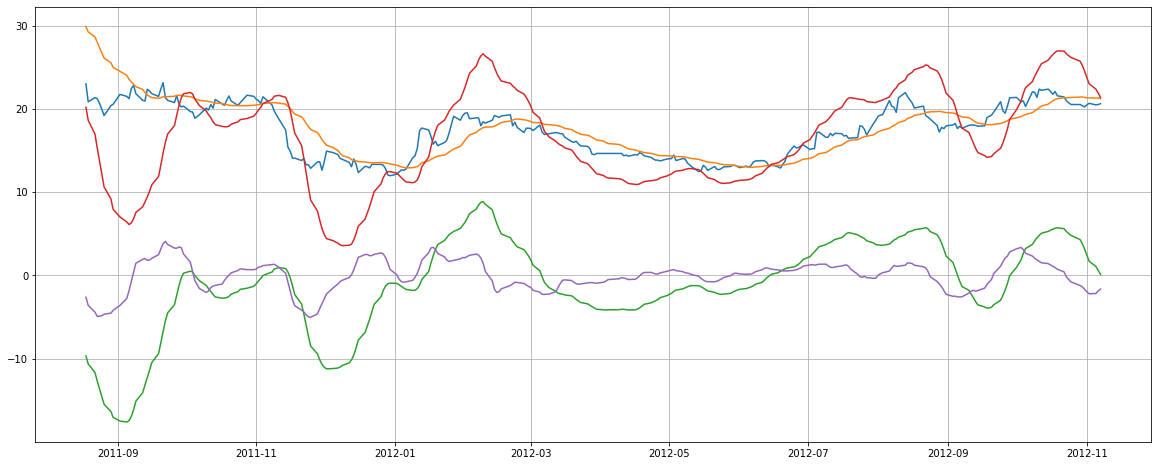

In [ ]:
a=1400
b = a+300
#plt.plot(df['Adj Close MA'][300:600])
#plt.plot(d_close[300:600])

plt.plot(df2['Adj Close'][a:b])
plt.plot(df2['Adj Close MA'][a:b])
plt.plot(df2['d_close'][a:b])
plt.plot(df2['d_dma'][a:b])
plt.plot(df2['d_aca'][a:b])

plt.grid()
plt.show()

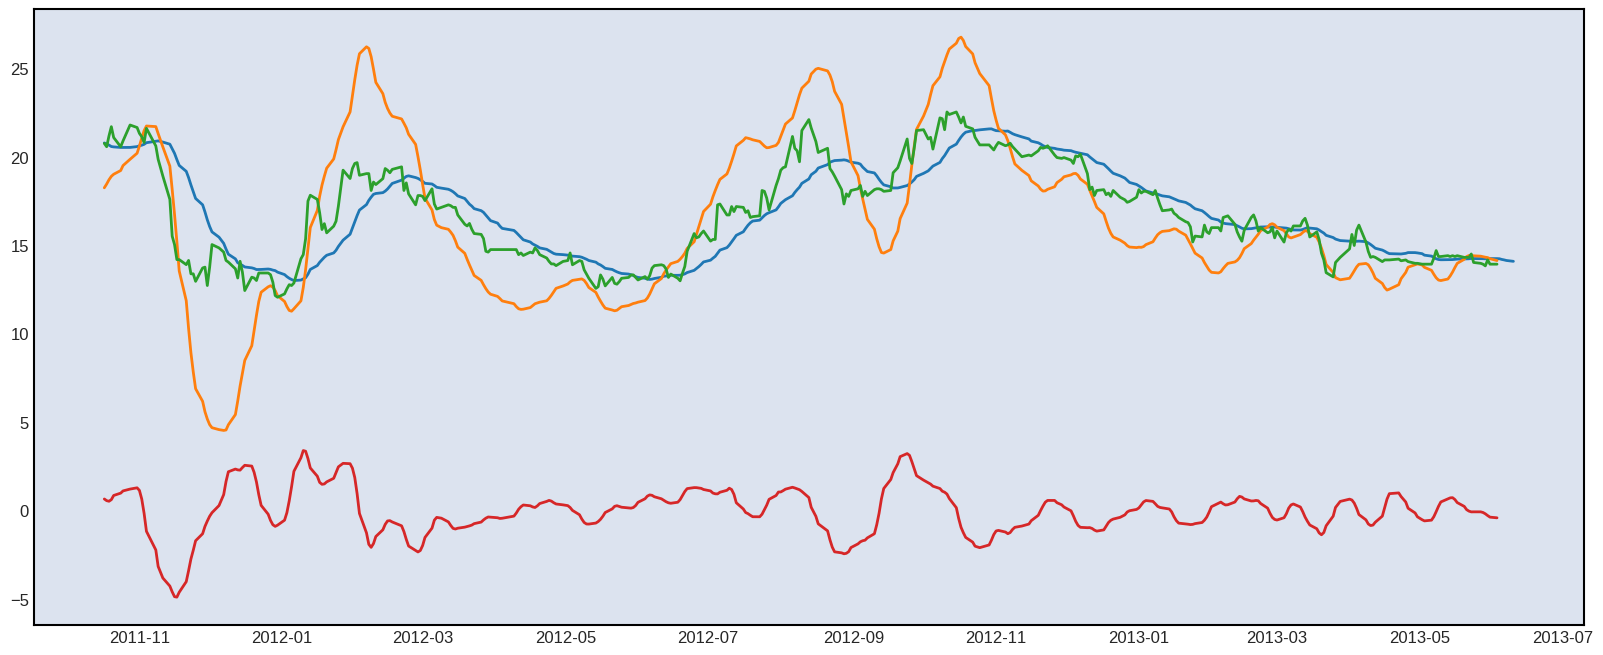

In [ ]:
a=1400
b = a+400
plt.plot(df['Adj Close MA'][a:b+5])
#plt.plot(d_close[300:600])
plt.plot(d_dma[a:b])
plt.plot(df['Adj Close'][a:b])
plt.plot(d_aca[a:b])
plt.grid()

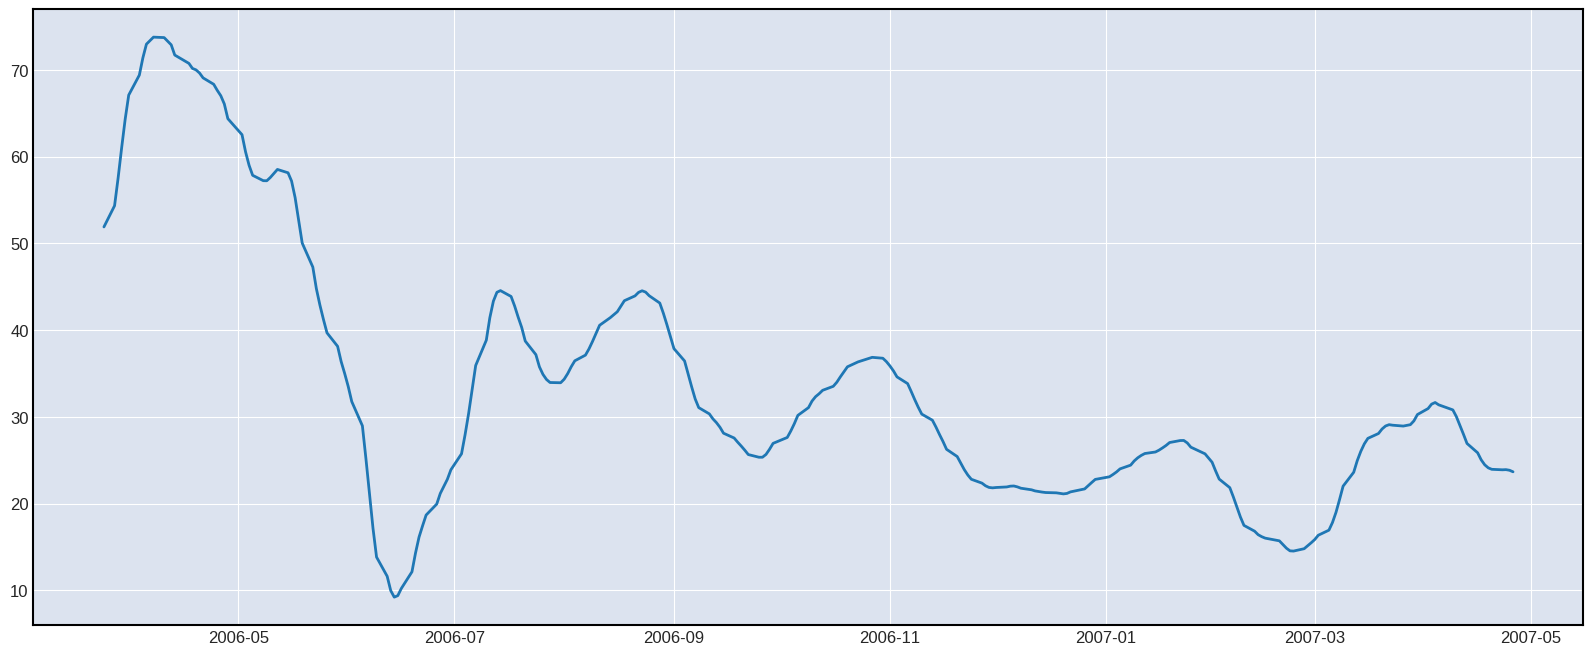

In [ ]:
plt.plot(d_dma[30:300])

In [ ]:
data = yf.download("TRIVENI.NS",interval='5m',start='2021-11-1', )

[*********************100%***********************]  1 of 1 completed


In [ ]:
data

,Open,High,Low,Close,Adj Close,Volume
Datetime,,,,,,
2021-11-01 09:15:00+05:30,192.750000,195.399994,192.750000,193.899994,193.899994,20706
2021-11-01 09:20:00+05:30,193.899994,193.949997,192.300003,192.300003,192.300003,14093
2021-11-01 09:25:00+05:30,192.350006,193.550003,192.050003,193.500000,193.500000,20511
2021-11-01 09:30:00+05:30,193.850006,194.399994,193.350006,194.399994,194.399994,9084
2021-11-01 09:35:00+05:30,194.100006,194.600006,193.850006,193.850006,193.850006,18527
2021-11-01 09:40:00+05:30,194.300003,194.300003,193.149994,194.000000,194.000000,9081
2021-11-01 09:45:00+05:30,193.850006,193.949997,193.250000,193.899994,193.899994,1741
2021-11-01 09:48:09+05:30,193.850006,193.850006,193.850006,193.850006,193.850006,0


In [ ]:
#base
class LSTMensembledLSTM(nn.Module):
  def __init__(self,models,dense,batch=64,pred_period=10,input_features=5,lstm_hid=64,lookout_days=100):
    super(LSTMensembledLSTM,self).__init__()
    self.models = models
    self.num_hidden=64
    self.device = ('cuda' if torch.cuda.is_available() else 'cpu')
    self.freeze_parameters_of_children()

    self.batch = batch
    self.period = pred_period 
    self.input_size = input_features
    self.hidden_size = lstm_hid
    self.dense_neurons = dense
    self.enc_seq_len = lookout_days

    self.lstm = nn.LSTM(input_size=len(self.models),hidden_size=self.num_hidden,num_layers=2,batch_first=True,bidirectional=True,bias = False, dropout=0.5)
    #self.dense = nn.Linear(in_features=self.num_hidden, out_features=128)
    self.dense2 = nn.Linear(in_features=dense, out_features = 1, bias = False)
    
    

    self.lstm_enc = nn.LSTM(input_size=self.input_size,hidden_size=self.hidden_size ,num_layers=1,batch_first=True)
    self.lstm_cell = nn.LSTMCell(input_size=self.hidden_size,hidden_size=self.hidden_size)
    self.act1 = nn.ReLU()
    self.attention = AdditiveAttention(hidden_state=self.hidden_size,num_hiddens=dense, period=self.enc_seq_len, dropout=0.5, batch=batch)
    self.dense1 = nn.Linear(in_features=self.hidden_size, out_features=self.dense_neurons)
    self.dense = nn.Linear(in_features=self.dense_neurons, out_features=1)
    self.dropout = nn.Dropout(0.6)
  def forward(self, inputs):
    
    
    
    
    
    predictions = torch.empty([inputs.shape[0],10,0],dtype=torch.float32,device=self.device)
    for i,model in enumerate(self.models):
        out = model(inputs)
        
        predictions = torch.cat([predictions,out],dim=-1)
    
    x,hidden = self.lstm(predictions)
    x = self.dense2(x)
    
    return x
  
  def freeze_parameters_of_children(self):
    models = []
    for model in self.models:
      for params in model.parameters():
        params.require_grad = False
      models.append(model.to(self.device))
    self.models = models
    return 

In [ ]:
#base

class LSTM(nn.Module):
  def __init__(self,batch,pred_period=10,lookout_days =100, lstm_hid = 128,dense = 512, input_features=5):
    super().__init__()
    self.batch = batch
    self.period = pred_period 
    self.input_size = input_features
    self.hidden_size = lstm_hid
    self.dense_neurons = dense
    self.enc_seq_len = lookout_days

    self.lstm = nn.LSTM(input_size=self.input_size,hidden_size=self.hidden_size ,num_layers=1,batch_first=True)
    self.lstm_cell = nn.LSTMCell(input_size=self.hidden_size,hidden_size=self.hidden_size)
    self.act1 = nn.ReLU()
    self.attention = AdditiveAttention(hidden_state=self.hidden_size,num_hiddens=dense, period=self.enc_seq_len, dropout=0.5, batch=batch)
    self.dense1 = nn.Linear(in_features=self.hidden_size, out_features=self.dense_neurons)
    self.dense = nn.Linear(in_features=self.dense_neurons, out_features=1)
    self.dropout = nn.Dropout(0.6)

  def forward(self,x):
    out,(hx,cx) = self.lstm(x)
    self.attention.load_hidden(out)
    hx = hx.squeeze()
    hidden = self.init_hidden()
    (hx1,cx1) =hidden
    
    output = torch.empty((self.period,self.batch,self.hidden_size))
    if torch.cuda.is_available():
        hx1,cx1 = hx1.cuda(),cx1.cuda()
        output = output.cuda()
    hx1 = hx
    for i in range(self.period):
      cnt = self.attention(hx1)
      
      hx1,cx1 = self.lstm_cell(cnt,(hx1,cx1))
      output[i] = hx1
      
    
    output = output.permute(1,0,2)
    output = self.act1(self.dropout(self.dense1(output)))
    output = self.dense(output)
    return output

  def init_hidden(self):
    return  (torch.zeros(self.batch,self.hidden_size ,dtype=torch.float32,requires_grad=True),
                   torch.zeros(self.batch,self.hidden_size ,dtype=torch.float32,requires_grad=True))
    
class AdditiveAttention(nn.Module):

  def __init__(self, hidden_state, num_hiddens,period, dropout,batch, **kwargs):
    super(AdditiveAttention, self).__init__()
    self.period = period
    self.W_enc = nn.Linear( hidden_state, num_hiddens, bias=False)
    
    self.W_hx = nn.Linear( hidden_state, num_hiddens ,bias=False)
    
    
    self.w_v = nn.Linear(num_hiddens,1,bias=False)
    self.w_u = nn.Linear(period,hidden_state,bias = False)
    self.dropout = nn.Dropout(dropout)
  def forward(self,hx1):
    hx = hx1.unsqueeze(axis=1).broadcast_to((hx1.shape[0],self.period,hx1.shape[1]))
    features = self.W_hx(hx) + self.W_enc(self.out_enc)
    scores= torch.tanh(self.dropout(self.w_v(features)))
    softmax = nn.functional.softmax(scores, dim=1)
    hx =  hx1.unsqueeze(1)
    
    weights = hx*softmax
    weights = torch.sum(weights, dim=1)
    
    
   
    return weights

  def load_hidden(self,out_enc):
    
    self.out_enc =out_enc
    return
    

In [ ]:
import torch

#new :CONV1d approach . BEst!! 
class AdditiveAttention(nn.Module):

  def __init__(self, hidden_state, num_hiddens,period, dropout,batch, **kwargs):
    super(AdditiveAttention, self).__init__()
    self.period = period
    self.W_enc = nn.Linear( hidden_state, num_hiddens, bias=False)
    
    self.W_hx = nn.Linear( hidden_state, num_hiddens ,bias=False)
    
    
    self.w_v = nn.Linear(num_hiddens,1,bias=False)
    self.w_u = nn.Linear(period,hidden_state,bias = False)
    self.dropout = nn.Dropout(dropout)
  def forward(self,hx1):
    hx = hx1.unsqueeze(axis=1).broadcast_to((hx1.shape[0],self.period,hx1.shape[1]))
    features = self.W_hx(hx) + self.W_enc(self.out_enc)
    scores= torch.tanh(self.dropout(self.w_v(features)))
    softmax = nn.functional.softmax(scores, dim=1)
    hx =  hx1.unsqueeze(1)
    
    weights = hx*softmax
    weights = torch.sum(weights, dim=1)
    
    
   
    return weights

  def load_hidden(self,out_enc):
    
    self.out_enc =out_enc
    return
    

class LSTM3(nn.Module):
  def __init__(self,batch,pred_period=10,lookout_days =100, lstm_hid = 64,dense = 256, input_features=4,teacher_enforce=0.5):
    super().__init__()
    self.batch = batch
    self.period = pred_period 
    self.input_size = input_features
    self.hidden_size = lstm_hid
    self.dense_neurons = dense
    self.enc_seq_len = lookout_days
    self.device = ("cuda" if torch.cuda.is_available() else "cpu")
    self.teacher_enforce = teacher_enforce

    self.lstm = nn.LSTM(input_size=self.input_size,hidden_size=self.hidden_size ,num_layers=2,batch_first=True)
    self.lstm_cell = nn.LSTMCell(input_size=1,hidden_size=self.hidden_size)
    self.lstm_cell2 = nn.LSTMCell(input_size=self.hidden_size,hidden_size=self.hidden_size)
    
    self.attention = AdditiveAttention(hidden_state=self.hidden_size,num_hiddens=dense, period=self.enc_seq_len, dropout=0.5, batch=batch)
    self.dense1 = nn.Linear(in_features=(self.hidden_size+ self.period), out_features=self.dense_neurons)
    self.dense = nn.Linear(in_features=self.dense_neurons, out_features=1)
    self.dropout = nn.Dropout(0.3)

    #New line
    self.act1 = nn.Sigmoid()
    self.act2 = nn.ReLU()
    #self.dense2 = nn.Linear(in_features=self.hidden_size, out_features=1,bias=False)
    
  def forward(self,x):
    x1 = x[:,:,0:-1]
    x = x[:,:,-1].unsqueeze(-1)
    
    out,(hx,cx) = self.lstm(x1)
    self.attention.load_hidden(out)

    hidden = self.init_hidden()
    (hx1,cx1) =hidden
    
    
    for i in range(self.enc_seq_len):
        hx1,cx1 = self.lstm_cell(x[:,i,:],(hx1,cx1))
        hx2 = self.attention(hx1)
        f = torch.rand([1],dtype=torch.float32,requires_grad = False, device=self.device)
        hx1 = (hx1 if f>self.teacher_enforce else hx2)


    
    input_len = self.enc_seq_len - self.period
    
    output = torch.empty((self.period,self.batch,(self.hidden_size+self.period)),device=self.device,dtype=torch.float32)
    
    for i in range(self.period):
      
      cnt = self.attention(hx1)
      #cnt = self.act2(self.dropout(self.dense2(cnt)))
      
      hx1,cx = self.lstm_cell2(cnt,(hx1,cx1))
      xx = x.squeeze()
      xx = xx[:,input_len:]
      
      hx2 = torch.cat([hx1,xx],dim=-1)
      
      output[i] = hx2
      
    
    output = output.permute(1,0,2)
    
    output = self.act1(self.dropout(self.dense1(output)))
    #new line
    
    output = self.dense(output)
    return output

  def init_hidden(self):
    return  (torch.zeros(self.batch,self.hidden_size ,dtype=torch.float32,requires_grad=True,device=self.device),
                   torch.zeros(self.batch,self.hidden_size ,dtype=torch.float32,requires_grad=True,device=self.device))
    
model = LSTM3((batch if batch else 32))
model.cuda()

#somewat performance boost . Still deplorable 
# change : added part of input to final dense

In [ ]:
#Conv1d with activiations
class AdditiveAttention(nn.Module):

  def __init__(self, y1 =128,y2=512,period=10, dropout=0.5,batch=32, **kwargs):
    super(AdditiveAttention, self).__init__()
    self.period = period
    self.W_enc = nn.Linear( y1+y2, y1, bias=False)
    
    
    
    self.act = nn.Tanh()
    
    
    self.dropout = nn.Dropout(dropout)
  def forward(self,y1,y2):
    y3 , y4 = y1.squeeze(),y2.squeeze()
    y = torch.cat([y3,y4],dim=-1)
    y = self.act(self.W_enc(y))
    y = nn.functional.softmax(y,dim=-1 )
    y = y.unsqueeze(1)
    yp = y.permute(0,2,1).broadcast_to((y1.shape[0],y1.shape[1],y1.shape[1]))
    
    weights = torch.bmm(yp,y1)
    
    
   
    return weights

class CNND2(nn.Module):
  def __init__(self,batch,pred_period=10,lookout_days =100,  input_features=5,teacher_enforce=0.5):
    super().__init__()
    self.batch = batch
    self.period = pred_period 
    self.enc_seq_len = lookout_days
    self.input_size = input_features
    
    
    self.device = ("cuda" if torch.cuda.is_available() else "cpu")
    self.teacher_enforce = teacher_enforce
    
    self.attention = AdditiveAttention(y1 =128,y2=512,period=10, dropout=0.5,batch=32)
    self.conv1 = nn.Conv1d(in_channels = self.input_size, out_channels= 32 ,kernel_size=3,stride=2)
    self.pool12= nn.MaxPool1d(kernel_size=3)
    self.pool13= nn.MaxPool1d(kernel_size=2)
    self.conv12 = nn.Conv1d(in_channels = 32, out_channels= 64 ,kernel_size=3,stride=2)
    self.conv123 = nn.Conv1d(in_channels = 64, out_channels= 128 ,kernel_size=3)

    self.conv2 = nn.Conv1d(in_channels = self.enc_seq_len, out_channels= 256 ,kernel_size=2)
    self.conv21 = nn.Conv1d(in_channels = 256, out_channels= 512 ,kernel_size=2)
    self.pool23 = nn.MaxPool1d(kernel_size=3)

    self.convT1 = nn.ConvTranspose1d(128,64,kernel_size=5)
    self.convT2 = nn.ConvTranspose1d(64,64,kernel_size=3)
    self.convT3 = nn.ConvTranspose1d(64,32,kernel_size=2)
    self.convT4 = nn.ConvTranspose1d(32,1,kernel_size=3)

    #New line
    self.dropout= nn.Dropout(0.4)
    self.act1 = nn.Sigmoid()
    self.act2 = nn.ReLU()
    #self.dense2 = nn.Linear(in_features=self.hidden_size, out_features=1,bias=False)
    
  def forward(self,inp):
    x = inp
    x1 = inp.permute(0,2,1)
    
    y1 = self.conv1(x1)
    y1 = self.act2(self.pool12(y1))
    y1= self.conv12(y1)
    y1 = self.dropout(self.pool13(y1))
    y1 = self.act2(self.conv123(y1))
    
    y2 = self.act2(self.conv2(x))
    y2 = self.conv21(y2)
    y2 = self.act2(self.pool23(y2))
    
    
    y1 = self.attention(y1,y2)

    

    z = self.act2(self.convT1(y1))
    z = self.act2(self.convT2(z))
    z = self.act2(self.convT3(z))
    z = self.convT4(z)
   
   
    return z.squeeze(1)

mod = CNND2(32)

#theoratical best 3.6 on trade loss

In [ ]:
EPOCHS_2=30
  #ens = LSTMensembledLSTM(MODELS)
  #ens.cuda()
L12=[]
L22=[]
for i in range(4):
  model_name_2=f"convk.pth"
  LEARNING_RATE = 1e-3
  loss_fn = tradeloss()

  optimizer = torch.optim.Adagrad(mod.parameters(),lr =LEARNING_RATE )
  lr_sch= lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

  history3 = train(mod, train_dataloader,val_dataloader,EPOCHS_2 , optimizer,loss_fn,scheduler=None,
          name=model_name_2, path=path)
  mod,l1,l2 = history3
  L12 = L12+l1
  L22 = L22+l2

Epoch: 1/30
		Going for validation
	Train loss:91.439626.. 	Valid Loss:36.822195..
	Validation loss decreased (inf --> 36.822195).  Saving model ...
	Epoch:1 completed in 0m 22s
Epoch: 2/30
		Going for validation
	Train loss:38.965606.. 	Valid Loss:28.990084..
	Validation loss decreased (36.822195 --> 28.990084).  Saving model ...
	Epoch:2 completed in 0m 22s
Epoch: 3/30
		Going for validation
	Train loss:31.088250.. 	Valid Loss:23.861103..
	Validation loss decreased (28.990084 --> 23.861103).  Saving model ...
	Epoch:3 completed in 0m 22s
Epoch: 4/30
		Going for validation
	Train loss:27.007622.. 	Valid Loss:19.397346..
	Validation loss decreased (23.861103 --> 19.397346).  Saving model ...
	Epoch:4 completed in 0m 22s
Epoch: 5/30
		Going for validation
	Train loss:24.143478.. 	Valid Loss:18.365445..
	Validation loss decreased (19.397346 --> 18.365445).  Saving model ...
	Epoch:5 completed in 0m 22s
Epoch: 6/30
		Going for validation
	Train loss:21.564154.. 	Valid Loss:17.707363..
	Va

In [ ]:
plt.plot(L12)
plt.plot(L22)
plot_data(mod,test_dataloader,days=8, rows=5,cols=5,randomized=True,random_range=2000)

In [ ]:
class AdditiveAttention(nn.Module):

  def __init__(self, y1 =128,y2=512,period=10, dropout=0.5,batch=32, **kwargs):
    super(AdditiveAttention, self).__init__()
    self.period = period
    self.W_enc = nn.Linear( y1+y2, y1, bias=False)
    
    
    
    self.act = nn.Tanh()
    
    
    self.dropout = nn.Dropout(dropout)
  def forward(self,y1,y2):
    y3 , y4 = y1.squeeze(),y2.squeeze()
    y = torch.cat([y3,y4],dim=-1)
    y = self.act(self.W_enc(y))
    y = nn.functional.softmax(y,dim=-1 )
    y = y.unsqueeze(1)
    yp = y.permute(0,2,1).broadcast_to((y1.shape[0],y1.shape[1],y1.shape[1]))
    
    weights = torch.bmm(yp,y1)
    
    
   
    return weights

class CNND(nn.Module):
  def __init__(self,batch,pred_period=10,lookout_days =100,  input_features=5,teacher_enforce=0.5):
    super().__init__()
    self.batch = batch
    self.period = pred_period 
    self.enc_seq_len = lookout_days
    self.input_size = input_features
    
    
    self.device = ("cuda" if torch.cuda.is_available() else "cpu")
    self.teacher_enforce = teacher_enforce
    
    self.attention = AdditiveAttention(y1 =128,y2=512,period=10, dropout=0.5,batch=32)
    self.conv1 = nn.Conv1d(in_channels = self.input_size, out_channels= 32 ,kernel_size=3,stride=2)
    self.pool12= nn.MaxPool1d(kernel_size=3)
    self.pool13= nn.MaxPool1d(kernel_size=2)
    self.conv12 = nn.Conv1d(in_channels = 32, out_channels= 64 ,kernel_size=3,stride=2)
    self.conv123 = nn.Conv1d(in_channels = 64, out_channels= 128 ,kernel_size=3)

    self.conv2 = nn.Conv1d(in_channels = self.enc_seq_len, out_channels= 256 ,kernel_size=2)
    self.conv21 = nn.Conv1d(in_channels = 256, out_channels= 512 ,kernel_size=2)
    self.pool23 = nn.MaxPool1d(kernel_size=3)

    self.convT1 = nn.ConvTranspose1d(128,64,kernel_size=5)
    self.convT2 = nn.ConvTranspose1d(64,64,kernel_size=3)
    self.convT3 = nn.ConvTranspose1d(64,32,kernel_size=2)
    self.convT4 = nn.ConvTranspose1d(32,1,kernel_size=3)

    #New line
    self.act1 = nn.Sigmoid()
    self.act2 = nn.ReLU()
    #self.dense2 = nn.Linear(in_features=self.hidden_size, out_features=1,bias=False)
    
  def forward(self,inp):
    x = inp
    x1 = inp.permute(0,2,1)
    
    y1 = self.conv1(x1)
    y1 = self.pool12(y1)
    y1= self.conv12(y1)
    y1 = self.pool13(y1)
    y1 = self.conv123(y1)
    
    y2 = self.conv2(x)
    y2 = self.conv21(y2)
    y2 = self.pool23(y2)
    
    
    y1 = self.attention(y1,y2)

    

    z = self.convT1(y1)
    z = self.convT2(z)
    z = self.convT3(z)
    z = self.convT4(z)
   
   
    return z.squeeze(1)

mod = CNND(32)

#theoratical best 3.6 on trade loss

In [ ]:
EPOCHS = 50
LEARNING_RATE = 1e-3
loss_fn = tradeloss()
#loss_fn = nn.MSELoss()
#loss_fn = nn.SmoothL1Loss()
loss1 = []
loss2 = []
for i in range(6):
  optimizer = torch.optim.Adagrad(mod.parameters(),lr =LEARNING_RATE )
  #lr_sch= lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)
  history1 = train(mod, train_dataloader,val_dataloader,EPOCHS , optimizer,loss_fn,scheduler=None,
          name="lstm_nov_11_4f.pth", path= path)
  mod, l1,l2 = history1
  loss1 = loss1 + l1
  loss2 = loss2 + l2


Epoch: 1/50
		Going for validation
	Train loss:75.898897.. 	Valid Loss:53.636224..
	Validation loss decreased (inf --> 53.636224).  Saving model ...
	Epoch:1 completed in 0m 23s
Epoch: 2/50
		Going for validation
	Train loss:40.237232.. 	Valid Loss:29.506388..
	Validation loss decreased (53.636224 --> 29.506388).  Saving model ...
	Epoch:2 completed in 0m 22s
Epoch: 3/50
		Going for validation
	Train loss:30.415758.. 	Valid Loss:23.074371..
	Validation loss decreased (29.506388 --> 23.074371).  Saving model ...
	Epoch:3 completed in 0m 23s
Epoch: 4/50
		Going for validation
	Train loss:25.482642.. 	Valid Loss:22.651603..
	Validation loss decreased (23.074371 --> 22.651603).  Saving model ...
	Epoch:4 completed in 0m 24s
Epoch: 5/50
		Going for validation
	Train loss:22.393847.. 	Valid Loss:19.571659..
	Validation loss decreased (22.651603 --> 19.571659).  Saving model ...
	Epoch:5 completed in 0m 23s
Epoch: 6/50
		Going for validation
	Train loss:20.423326.. 	Valid Loss:18.000075..
	Va

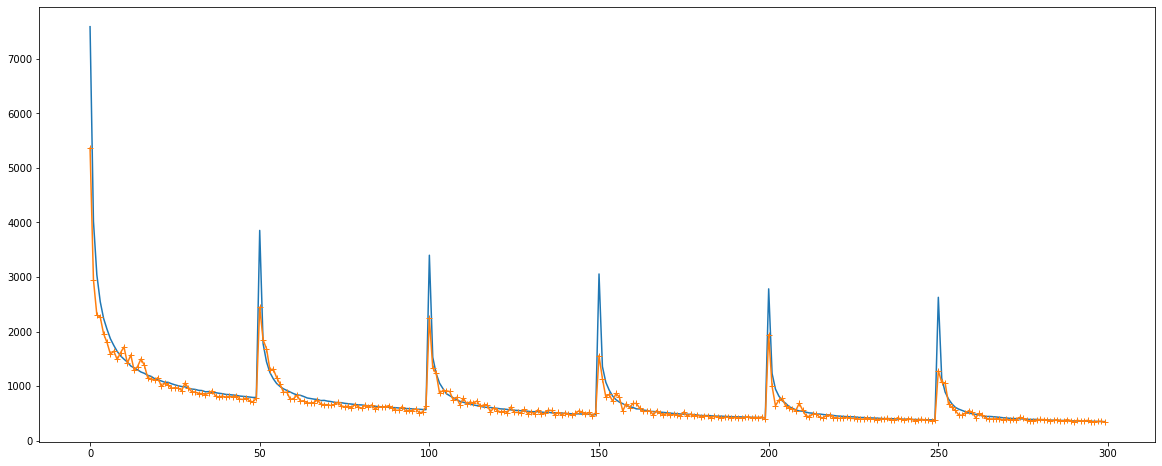

In [ ]:
mod,l1,l2 = history1
plt.plot(loss1,label='train_loss')
plt.plot(loss2, marker = '+',label='val_loss')

(21280, 10)
[1257   63  789 1822  151  854 1034 1414  231 1802  594 1983   24  879
 1513    7  875 1509 1214   90 1220 1842 1417  340 1464    8 1903  792
  385  769 1554 1062 1582 1977 1933  576  810   59 1421 1929  755  403
  222 1465 1830  535 1674  980 1417 1325 1478 1820  582 1651 1972 1501
 1407 1632  690 1833  257  474 1234 1502  441 1950  652  131  890  449
  257  743  754 1867 1504 1644 1760  875 1275  988]
[0.03274142 0.03366012 0.0345533  0.03480849 0.03496161 0.03505093
 0.03516576 0.03526784 0.0355358  0.03585479]


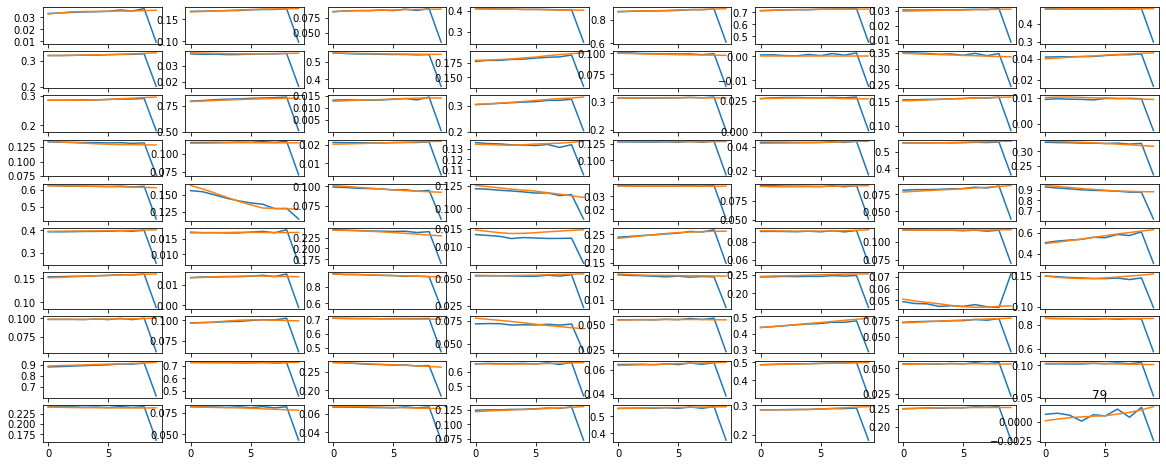

In [ ]:

plot_data(mod,train_dataloader,random_range = 2000, randomized = True)